In [47]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
#from visualization.general_overvies import *
from visualization.consolidated_plots import *
from visualization.general_overvies import load_simulation_data
from classify_end_states import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def plot_opinion_trajectory(data, who = 0, fig = None, ax = None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 5))

    time = data["save_steps"]
    subdata = data["opinions"][who]

    for v in range(100):
        color = value_to_color(subdata[0,v])
        ax.plot(time, subdata[:,v], color=color)
    
    return fig, ax

In [5]:
def fraction_time_polarized(subdata, min_agents_per_extreme=10, extreme_threshold=0.8):
    """
    Calculate fraction of time when at least min_agents_per_extreme agents 
    are stuck in both extreme bins (< -extreme_threshold and > extreme_threshold)
    """
    n_humans = subdata['parameters']['n_humans']
    opinion_bins = subdata['opinion_bins']  # shape: (n_replicas, n_steps, 20)
    
    # Find which bins correspond to extreme opinions
    bin_edges = subdata['bin_edges']
    extreme_negative_bins = bin_edges[:-1] < -extreme_threshold  # bins < -0.8
    extreme_positive_bins = bin_edges[:-1] > extreme_threshold   # bins > 0.8
    
    results = []
    for replica in range(subdata['n_replicas']):
        # Sum agents in extreme bins for each time step
        negative_agents = np.sum(opinion_bins[replica, -1, extreme_negative_bins]) * n_humans
        positive_agents = np.sum(opinion_bins[replica, -1, extreme_positive_bins]) * n_humans
        
        # Check when both extremes have enough agents
        both_polarized = (negative_agents >= min_agents_per_extreme) & (positive_agents >= min_agents_per_extreme)
        
        fraction_polarized = np.mean(both_polarized)
        results.append(fraction_polarized)
    
    return np.array(results)

In [7]:
data_no_bots = load_simulation_data(
    data_dir=r"C:\Users\nel_t\Documents\WORK\PROJECTS\Boosting Bots\data\09_07_25\No_bots_sigma_experiment",
    file_pattern="results_ce*_th*_nb*",  # Include all 3 params
    param_names=["ce", "th", "nb"],      # Use all 3 param names
    date_suffix=None
)
data_no_bots = {(ce, nb): data for (ce, th, nb), data in data_no_bots.items()}

Loaded: ce=0.05, th=0.0, nb=0.0
Loaded: ce=0.15, th=0.0, nb=0.0
Loaded: ce=0.1, th=0.0, nb=0.0
Loaded: ce=0.25, th=0.0, nb=0.0
Loaded: ce=0.2, th=0.0, nb=0.0
Loaded: ce=0.35, th=0.0, nb=0.0
Loaded: ce=0.3, th=0.0, nb=0.0
Loaded: ce=0.45, th=0.0, nb=0.0
Loaded: ce=0.4, th=0.0, nb=0.0
Loaded: ce=0.5, th=0.0, nb=0.0
Loaded: ce=0.0, th=0.0, nb=0.0

Loaded 11 files total


In [126]:
baseline = load_simulation_data(
    data_dir=r"C:\Users\nel_t\Documents\WORK\PROJECTS\Boosting Bots\data\09_07_25\1000_SIR_random",
    file_pattern="results_ce*_th*_nb*",  # Include all 3 params
    param_names=["ce", "th", "nb"],      # Use all 3 param names
    date_suffix=None
)
baseline_data = {(ce, nb): data for (ce, th, nb), data in baseline.items()}

Loaded: ce=0.3, th=0.0, nb=0.0

Loaded 1 files total


Simple Classification:
Extreme consensus:  0 ( 0.0%)
Extreme polarization:  0 ( 0.0%)
Something else: 100 (100.0%)

Total: 100 replicas
Simple Classification:
Extreme consensus:  6 ( 6.0%)
Extreme polarization:  0 ( 0.0%)
Something else: 94 (94.0%)

Total: 100 replicas
Simple Classification:
Extreme consensus:  6 ( 6.0%)
Extreme polarization:  0 ( 0.0%)
Something else: 94 (94.0%)

Total: 100 replicas
Simple Classification:
Extreme consensus: 30 (30.0%)
Extreme polarization:  0 ( 0.0%)
Something else: 70 (70.0%)

Total: 100 replicas
Simple Classification:
Extreme consensus: 36 (36.0%)
Extreme polarization:  0 ( 0.0%)
Something else: 64 (64.0%)

Total: 100 replicas
Simple Classification:
Extreme consensus: 60 (60.0%)
Extreme polarization:  1 ( 1.0%)
Something else: 39 (39.0%)

Total: 100 replicas
Simple Classification:
Extreme consensus: 68 (68.0%)
Extreme polarization:  6 ( 6.0%)
Something else: 26 (26.0%)

Total: 100 replicas
Simple Classification:
Extreme consensus: 80 (80.0%)
Extreme

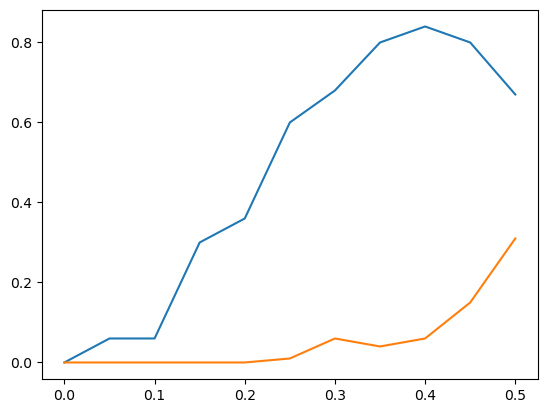

In [52]:
L = len(sigmas)

consensuses = np.zeros(L)
polarizations = np.zeros(L)

for i in range(L):
    frequencies = get_simple_frequencies(data_no_bots[(sigmas[i], 0.0)])
    consensuses[i] = frequencies[1]
    polarizations[i] = frequencies[2]

plt.plot(sigmas, consensuses, label = "Consensus")
plt.plot(sigmas, polarizations, label = "Extreme polarization")

print(consensuses)
print(polarizations)

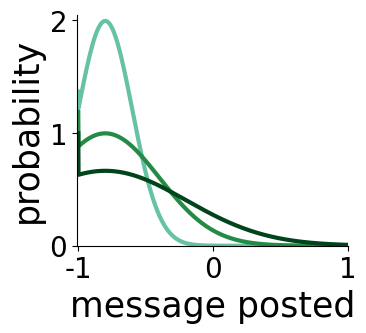

In [83]:
import numpy as np
from scipy.special import erf

def gaussian_distribution(x, mu, sigma):
    # Standard gaussian
    Y = np.exp(-(x - mu)**2 / (2 * sigma**2)) / (sigma * np.sqrt(2 * np.pi))
    
    # Calculate clipped mass using error function
    # P(X < -1) = 0.5 * (1 + erf((-1 - mu) / (sigma * sqrt(2))))
    prob_below_minus1 = 0.5 * (1 + erf((-1 - mu) / (sigma * np.sqrt(2))))
    prob_above_plus1 = 0.5 * (1 - erf((1 - mu) / (sigma * np.sqrt(2))))
    
    # Add clipped mass to endpoints
    Y[0] += prob_below_minus1
    Y[-1] += prob_above_plus1
    
    return Y

colors = ['#66c2a4','#238b45','#00441b']
x = np.linspace(-1, 1, 1000)

fig, ax = plt.subplots(figsize=(3.5, 3))
ax.plot(x, gaussian_distribution(x, -0.8, 0.2), linewidth=3, color=colors[0])
ax.plot(x, gaussian_distribution(x, -0.8, 0.4), linewidth=3, color=colors[1])
ax.plot(x, gaussian_distribution(x, -0.8, 0.6), linewidth=3, color=colors[2])



# remove top and left spines:
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticks([-1, 0, 1])
ax.set_yticks([0, 1, 2])
ax.set_xlabel("message posted", fontsize=25)
ax.set_ylabel("probability", fontsize=25)
ax.set_xlim(-1.01, 1)
ax.set_ylim(0, 2.05)
ax.set_xticklabels([-1, 0, 1], fontsize=20)
ax.set_yticklabels([0, 1, 2], fontsize=20)




fig.savefig("gaussian_distribution.pdf", dpi=300, bbox_inches="tight")


[0.   0.   0.   0.   0.   0.01 0.06 0.04 0.06 0.15 0.31]


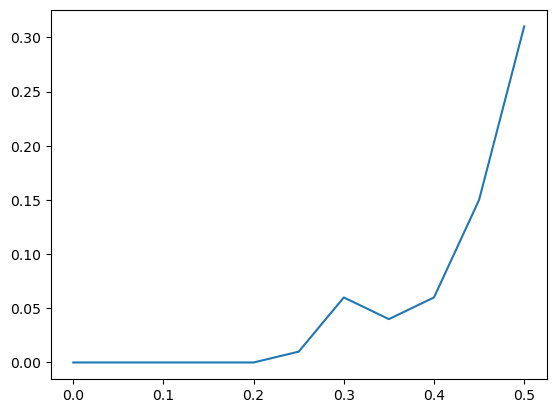

In [19]:
fraction_of_polarized = np.zeros(len(data_no_bots))
sigmas = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

for i in range(len(data_no_bots)):
    pol = fraction_time_polarized(data_no_bots[(sigmas[i], 0.0)], min_agents_per_extreme=20)
    fraction_of_polarized[i] = np.mean(pol)


print(fraction_of_polarized)
plt.plot(sigmas, fraction_of_polarized)


In [140]:
def layout(fig, ax, xlim = (0, 10000)):
    # remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #ax.set_xlabel("time", fontsize=18)
    ax.set_ylabel("opinion", fontsize=18)
    ax.set_xlim(xlim[0], xlim[1])
    ax.set_xticks([0, xlim[1]/2, xlim[1]])
    ax.set_xticklabels([], fontsize=18)
    ax.set_ylim(-1, 1)
    ax.set_yticks([-1, 0, 1])
    ax.set_yticklabels([-1, 0, 1], fontsize=18)

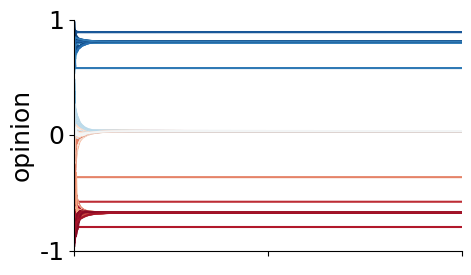

In [134]:
fig, ax = plt.subplots(figsize=(5, 3))
subdata = data_no_bots[(sigmas[0], 0.0)]
plot_opinion_trajectory(subdata, 0, ax = ax)
layout(fig, ax)


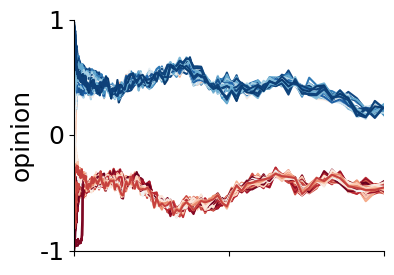

In [135]:
fig, ax = plt.subplots(figsize=(4, 3))
subdata = data_no_bots[(sigmas[2], 0.0)]
plot_opinion_trajectory(subdata, 2, ax = ax)
layout(fig, ax)

fig.savefig("OD_disjoint.pdf", dpi=300, bbox_inches="tight")

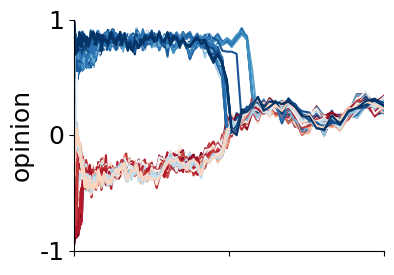

In [136]:
fig, ax = plt.subplots(figsize=(4, 3))
subdata = data_no_bots[(sigmas[3], 0.0)]
plot_opinion_trajectory(subdata, 0, ax = ax)
layout(fig, ax)
fig.savefig("OD_joint.pdf", dpi=300, bbox_inches="tight")

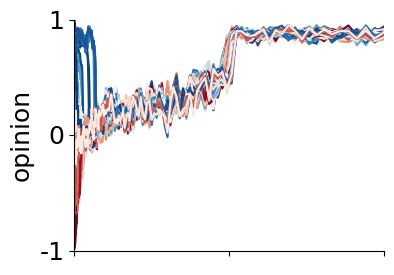

In [137]:
fig, ax = plt.subplots(figsize=(4, 3))
subdata = data_no_bots[(sigmas[5], 0.0)]
plot_opinion_trajectory(subdata, 0, ax = ax)
layout(fig, ax)
fig.savefig("OD_joint_extreme.pdf", dpi=300, bbox_inches="tight")

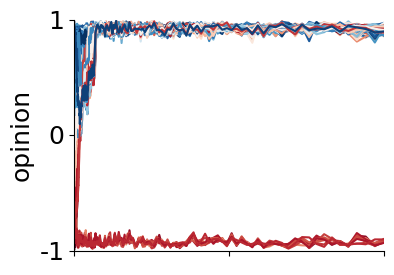

In [138]:
fig, ax = plt.subplots(figsize=(4, 3))
subdata = data_no_bots[(sigmas[-2], 0.0)]
plot_opinion_trajectory(subdata, 1, ax = ax)
layout(fig, ax)
fig.savefig("OD_disjoint_extreme.pdf", dpi=300, bbox_inches="tight")

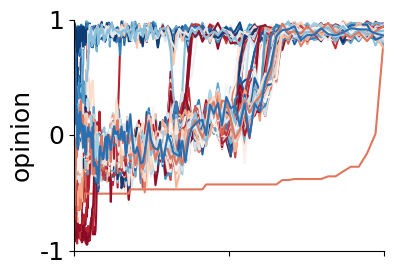

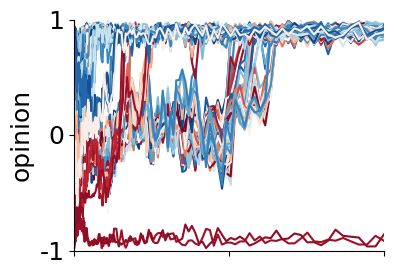

In [145]:
fig, ax = plt.subplots(figsize=(4, 3))
subdata = baseline[(0.3, 0.0, 0)]
plot_opinion_trajectory(subdata, 3, ax = ax)
layout(fig, ax, xlim = (0, 5000))
fig.savefig("baseline1.pdf", dpi=300, bbox_inches="tight")

fig, ax = plt.subplots(figsize=(4, 3))
subdata = baseline[(0.3, 0.0, 0)]
plot_opinion_trajectory(subdata, 0, ax = ax)
layout(fig, ax, xlim = (0, 5000))
fig.savefig("baseline2.pdf", dpi=300, bbox_inches="tight")




In [144]:
frequencies = get_simple_frequencies(subdata)

frequencies = get_simple_frequencies(data_no_bots[(sigmas[6], 0.0)])



Simple Classification:
Extreme consensus: 65 (65.0%)
Extreme polarization:  2 ( 2.0%)
Something else: 33 (33.0%)

Total: 100 replicas
Simple Classification:
Extreme consensus: 68 (68.0%)
Extreme polarization:  6 ( 6.0%)
Something else: 26 (26.0%)

Total: 100 replicas


(None, <Axes: >)

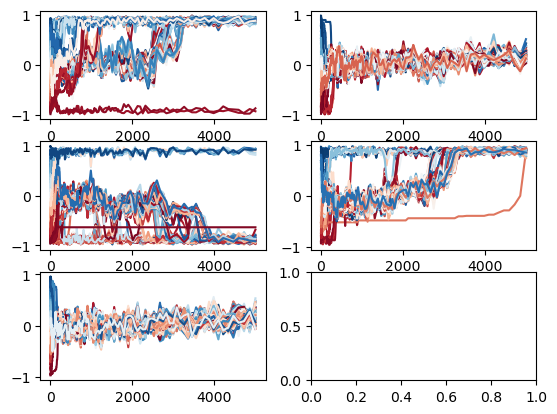

In [ ]:
fig, axs = plt.subplots(3,2)
subdata = baseline_data

plot_opinion_trajectory(baseline_data, 0, ax = axs[0,0])
plot_opinion_trajectory(baseline_data, 1, ax = axs[0,1])
plot_opinion_trajectory(baseline_data, 2, ax = axs[1,0])
plot_opinion_trajectory(baseline_data, 3, ax = axs[1,1])
plot_opinion_trajectory(baseline_data, 4, ax = axs[2,0])




In [147]:
data_with_bots = load_simulation_data(
    data_dir=r"C:\Users\nel_t\Documents\WORK\PROJECTS\Boosting Bots\data\09_07_25\1000_100_discrete_ce03",
    file_pattern="results_ce*_th*_nb*",  # Include all 3 params
    param_names=["ce", "th", "nb"],      # Use all 3 param names
    date_suffix=None
)
bot_data_1000 = {(th, nb): data for (ce, th, nb), data in data_with_bots.items()}

Loaded: ce=0.3, th=-0.2, nb=0.0
Loaded: ce=0.3, th=-0.2, nb=10.0
Loaded: ce=0.3, th=-0.2, nb=12.0
Loaded: ce=0.3, th=-0.2, nb=16.0
Loaded: ce=0.3, th=-0.2, nb=1.0
Loaded: ce=0.3, th=-0.2, nb=20.0
Loaded: ce=0.3, th=-0.2, nb=24.0
Loaded: ce=0.3, th=-0.2, nb=2.0
Loaded: ce=0.3, th=-0.2, nb=32.0
Loaded: ce=0.3, th=-0.2, nb=3.0
Loaded: ce=0.3, th=-0.2, nb=4.0
Loaded: ce=0.3, th=-0.2, nb=5.0
Loaded: ce=0.3, th=-0.2, nb=64.0
Loaded: ce=0.3, th=-0.2, nb=6.0
Loaded: ce=0.3, th=-0.2, nb=8.0
Loaded: ce=0.3, th=-0.4, nb=0.0
Loaded: ce=0.3, th=-0.4, nb=10.0
Loaded: ce=0.3, th=-0.4, nb=12.0
Loaded: ce=0.3, th=-0.4, nb=16.0
Loaded: ce=0.3, th=-0.4, nb=1.0
Loaded: ce=0.3, th=-0.4, nb=20.0
Loaded: ce=0.3, th=-0.4, nb=24.0
Loaded: ce=0.3, th=-0.4, nb=2.0
Loaded: ce=0.3, th=-0.4, nb=32.0
Loaded: ce=0.3, th=-0.4, nb=3.0
Loaded: ce=0.3, th=-0.4, nb=4.0
Loaded: ce=0.3, th=-0.4, nb=5.0
Loaded: ce=0.3, th=-0.4, nb=64.0
Loaded: ce=0.3, th=-0.4, nb=6.0
Loaded: ce=0.3, th=-0.4, nb=8.0
Loaded: ce=0.3, th=-0.6, n

In [157]:
thresholds = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
n_bots =  [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 32, 64]

In [186]:
frequencies = get_simple_frequencies(subdata)

Restrictive Classification:
Extremely negative  : 58 (58.0%)
Extremely positive  :  0 ( 0.0%)
Extremely extremist :  0 ( 0.0%)
Something else      : 42 (42.0%)

Total: 100 replicas

Thresholds:
  Extremely negative: >80% below -0.8
  Extremely positive: >80% above +0.8
  Extremely extremist: >10% above +0.8, >10% below -0.8, <20% in middle


In [192]:
frequencies [1]

0.34

In [196]:
extreme_negative = np.zeros((len(thresholds), len(n_bots)))
extreme_positive = np.zeros((len(thresholds), len(n_bots)))
extreme_polarization = np.zeros((len(thresholds), len(n_bots)))


for i, th in enumerate(thresholds):
    for j, nb in enumerate(n_bots):
        subdata = bot_data_1000[(th, nb)]
        frequencies = get_simple_frequencies(subdata)
        extreme_negative[i, j] = frequencies[1]
        extreme_positive[i, j] = frequencies[2]
        extreme_polarization[i, j] = frequencies[3]

Restrictive Classification:
Extremely negative  : 34 (34.0%)
Extremely positive  :  0 ( 0.0%)
Extremely extremist :  8 ( 8.0%)
Something else      : 58 (58.0%)

Total: 100 replicas

Thresholds:
  Extremely negative: >80% below -0.8
  Extremely positive: >80% above +0.8
  Extremely extremist: >10% above +0.8, >10% below -0.8, <20% in middle
Restrictive Classification:
Extremely negative  : 37 (37.0%)
Extremely positive  :  0 ( 0.0%)
Extremely extremist : 10 (10.0%)
Something else      : 53 (53.0%)

Total: 100 replicas

Thresholds:
  Extremely negative: >80% below -0.8
  Extremely positive: >80% above +0.8
  Extremely extremist: >10% above +0.8, >10% below -0.8, <20% in middle
Restrictive Classification:
Extremely negative  : 40 (40.0%)
Extremely positive  :  0 ( 0.0%)
Extremely extremist : 14 (14.0%)
Something else      : 46 (46.0%)

Total: 100 replicas

Thresholds:
  Extremely negative: >80% below -0.8
  Extremely positive: >80% above +0.8
  Extremely extremist: >10% above +0.8, >10% b

In [ ]:


# Select every 2nd or 3rd tick for cleaner display
x_tick_indices = np.arange(0, len(thresholds), 2)  # every 2nd threshold
y_tick_indices = np.arange(0, len(n_bots), 3)      # every 3rd n_bot value

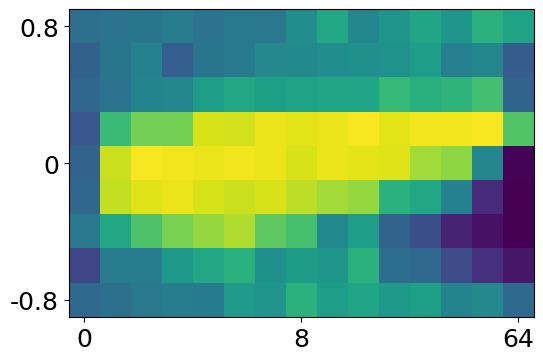

In [224]:


fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(np.flipud(extreme_negative), cmap="viridis", vmin=0, vmax=1, aspect="auto")

ax.set_yticks(np.flip(x_tick_indices))
ax.set_xticks(y_tick_indices)
ax.set_yticklabels([thresholds[i] for i in x_tick_indices], fontsize=18)
ax.set_xticklabels([n_bots[i] for i in y_tick_indices], fontsize=18)

#cbar = fig.colorbar(ax.imshow(extreme_negative.T, cmap="viridis", vmin=0, vmax=1, aspect="auto"), ax=ax)
fig.savefig("extreme_negative.pdf", dpi=300, bbox_inches="tight")

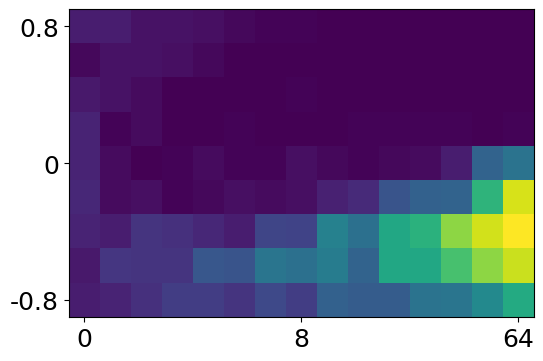

In [221]:
thresholds = [-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8]
n_bots =  [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 32, 64]
# Select every 2nd or 3rd tick for cleaner display
x_tick_indices = np.arange(0, len(thresholds), 4)  # every 2nd threshold
y_tick_indices = np.arange(0, len(n_bots), 7)      # every 3rd n_bot value

fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(np.flipud(extreme_polarization), cmap="viridis", vmin=0, vmax=1, aspect="auto")

ax.set_yticks(np.flip(x_tick_indices))
ax.set_xticks(y_tick_indices)
ax.set_yticklabels([thresholds[i] for i in x_tick_indices], fontsize=18)
ax.set_xticklabels([n_bots[i] for i in y_tick_indices], fontsize=18)

fig.savefig("extreme_polarization.pdf", dpi=300, bbox_inches="tight")


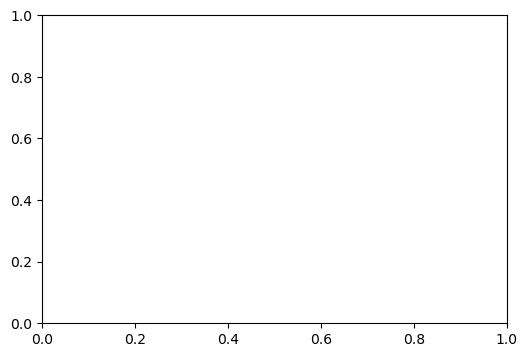

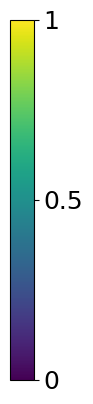

In [227]:
# plot a simple colorbar with no other data and 3 ticks

fig, ax = plt.subplots(figsize=(6, 4))
from matplotlib.colors import Normalize

fig, ax = plt.subplots(figsize=(1.2, 4))
fig.subplots_adjust(left=0.4, right=0.7)
fig.delaxes(ax)

norm = Normalize(vmin=0, vmax=1)
cbar = fig.colorbar(
    plt.cm.ScalarMappable(norm=norm, cmap="viridis"),
    cax=fig.add_axes([0.4, 0.05, 0.2, 0.9]),
    ticks=[0, 0.5, 1]
)
cbar.ax.set_yticklabels(['0', '0.5', '1'], fontsize=18)


# save the colorbar as a separate figure
fig.savefig("colorbar_only.pdf", dpi=300, bbox_inches="tight")



In [ ]:


grid_data, grid_titles, grid_shape = prepare_heatmap_grid(
    data_no_bots, param1_values=[0, 0.2, 0.5], param2_values=[0],
    param1_name="ce", param2_name="nb", max_time_steps=2000, param1_is_rows=False
)

Loaded: ce=0.05, th=0.0, nb=0.0
Loaded: ce=0.15, th=0.0, nb=0.0
Loaded: ce=0.1, th=0.0, nb=0.0
Loaded: ce=0.25, th=0.0, nb=0.0
Loaded: ce=0.2, th=0.0, nb=0.0
Loaded: ce=0.35, th=0.0, nb=0.0
Loaded: ce=0.3, th=0.0, nb=0.0
Loaded: ce=0.45, th=0.0, nb=0.0
Loaded: ce=0.4, th=0.0, nb=0.0
Loaded: ce=0.5, th=0.0, nb=0.0
Loaded: ce=0.0, th=0.0, nb=0.0

Loaded 11 files total


In [40]:
grid_data, grid_titles, grid_shape = prepare_heatmap_grid_enhanced( data_no_bots,
    param1_values=[0, 0.2, 0.5], param2_values=[0],
    param1_name="ce", param2_name="nb", max_time_steps=2000, param1_is_rows=False, polarization_metric="both")

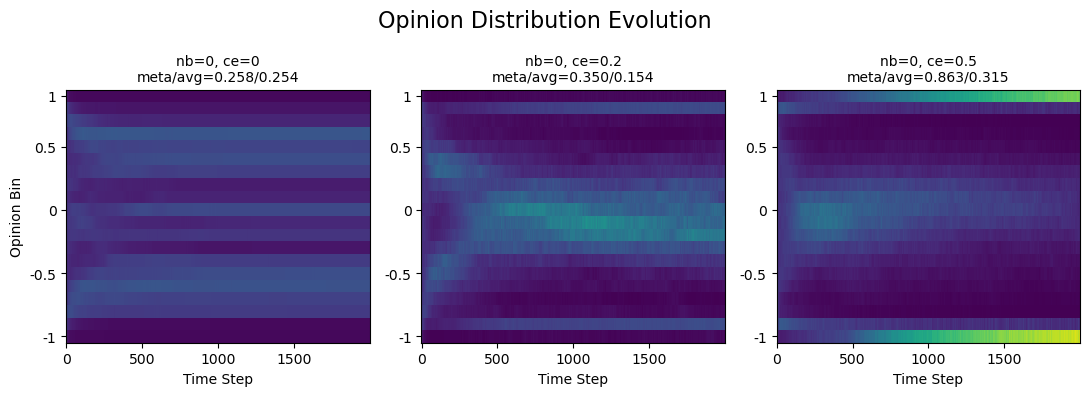

In [42]:
fig, axs = plot_heatmap_grid(
    grid_data, grid_titles, grid_shape,
    colorbar=False, custom_yticks=([0, 5, 10, 15, 19], [-1, -0.5, 0, 0.5, 1])
)

In [48]:
len(data_no_bots[(0.05, 0.0)]["opinions"][0][0])

100

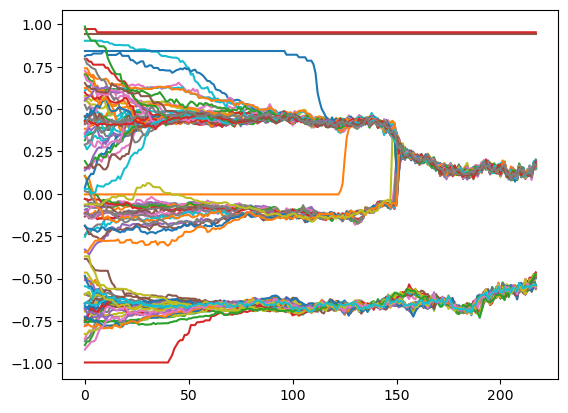

In [18]:
# Debug your data structure
print("Keys in data_no_bots:", list(data_no_bots.keys())[:3])  # First 3 keys
print()

# Pick one dataset to examine
sample_key = list(data_no_bots.keys())[0]
sample_data = data_no_bots[sample_key]

print(f"Sample key: {sample_key}")
print(f"Sample data type: {type(sample_data)}")
print(f"Sample data keys: {list(sample_data.keys()) if hasattr(sample_data, 'keys') else 'No keys method'}")
print()

# Check if bin_edges exists and its type
if 'bin_edges' in sample_data:
    print(f"bin_edges type: {type(sample_data['bin_edges'])}")
    print(f"bin_edges value: {sample_data['bin_edges']}")
else:
    print("'bin_edges' not found in sample data")
    
# Check opinion_bins shape
if 'opinion_bins' in sample_data:
    print(f"opinion_bins shape: {sample_data['opinion_bins'].shape}")
else:
    print("'opinion_bins' not found")

Keys in data_no_bots: [(0.05, 0.0), (0.15, 0.0), (0.1, 0.0)]

Sample key: (0.05, 0.0)
Sample data type: <class 'numpy.ndarray'>
Sample data keys: No keys method

'bin_edges' not found in sample data
'opinion_bins' not found


In [19]:
sample_data = data_no_bots[(0.05, 0.0)]
print(f"Array shape: {sample_data.shape}")
print(f"Array dtype: {sample_data.dtype}")

Array shape: (20, 10000)
Array dtype: float32


In [11]:
plot_heatmap_grid(data_no_bots, 
                 param1_values=[0, 0.1, 0.2, 0.3,0.4,0.5], 
                 param2_values= [0],
                 param1_name="ce", 
                 param2_name="nb", param1_is_rows=False)

TypeError: plot_heatmap_grid() missing 1 required positional argument: 'polarization_vars'

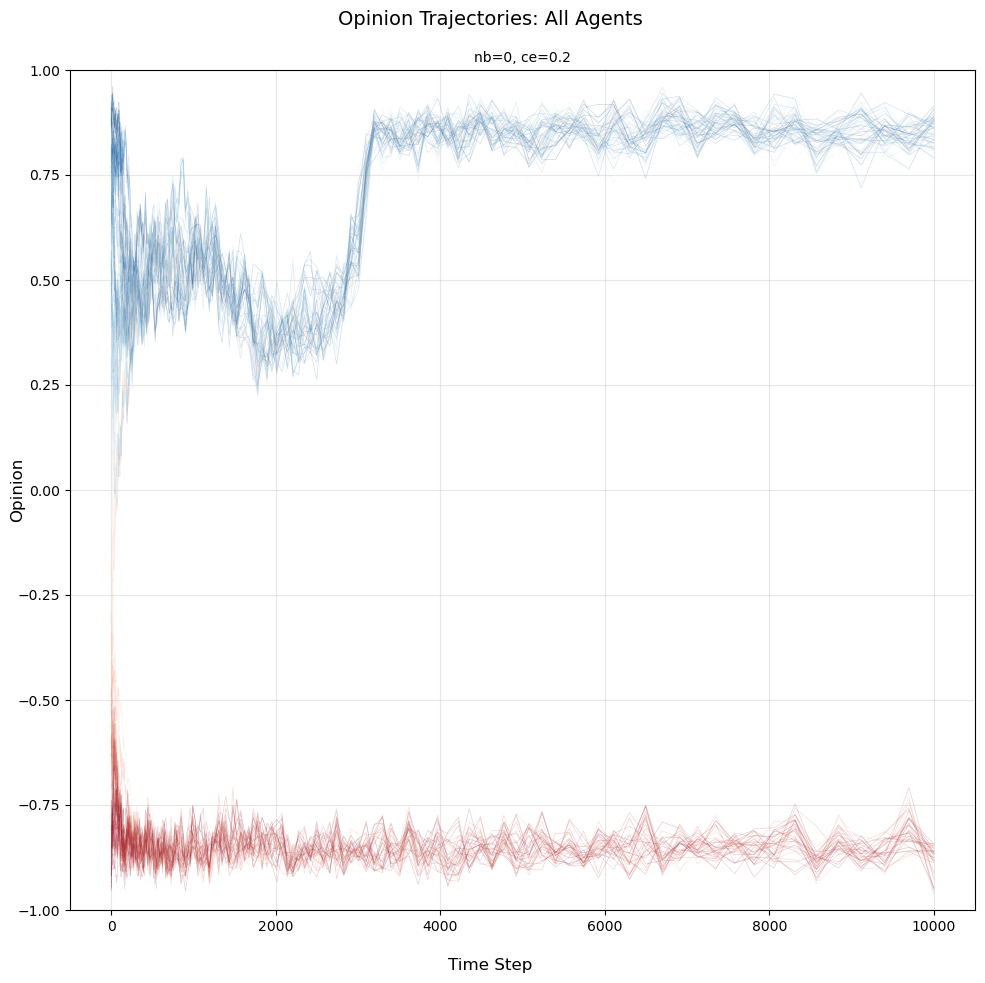

(<Figure size 1000x1000 with 1 Axes>,
 array([[<Axes: title={'center': 'nb=0, ce=0.2'}>]], dtype=object))

In [92]:
plot_opinion_trajectories(data_no_bots, 
                 param1_values=[0.2], 
                 param2_values= [0],
                 param1_name="ce", 
                 param2_name="nb", 
                 param1_is_rows=False, 
                 figsize=(10, 10), 
                 alpha = 0.2)

In [3]:
data_with_bots = load_simulation_data(
    data_dir=r"C:\Users\nel_t\Documents\WORK\PROJECTS\Boosting Bots\data\09_07_25\1000_100_discrete",
    file_pattern="results_ce*_th*_nb*",  # Include all 3 params
    param_names=["ce", "th", "nb"],      # Use all 3 param names
    date_suffix=None
)
bot_data_1000 = {(th, nb): data for (ce, th, nb), data in data_with_bots.items()}

Loaded: ce=0.2, th=-0.2, nb=0.0
Loaded: ce=0.2, th=-0.2, nb=10.0
Loaded: ce=0.2, th=-0.2, nb=12.0
Loaded: ce=0.2, th=-0.2, nb=16.0
Loaded: ce=0.2, th=-0.2, nb=1.0
Loaded: ce=0.2, th=-0.2, nb=20.0
Loaded: ce=0.2, th=-0.2, nb=24.0
Loaded: ce=0.2, th=-0.2, nb=2.0
Loaded: ce=0.2, th=-0.2, nb=32.0
Loaded: ce=0.2, th=-0.2, nb=3.0
Loaded: ce=0.2, th=-0.2, nb=4.0
Loaded: ce=0.2, th=-0.2, nb=5.0
Loaded: ce=0.2, th=-0.2, nb=64.0
Loaded: ce=0.2, th=-0.2, nb=6.0
Loaded: ce=0.2, th=-0.2, nb=8.0
Loaded: ce=0.2, th=-0.4, nb=0.0
Loaded: ce=0.2, th=-0.4, nb=10.0
Loaded: ce=0.2, th=-0.4, nb=12.0
Loaded: ce=0.2, th=-0.4, nb=16.0
Loaded: ce=0.2, th=-0.4, nb=1.0
Loaded: ce=0.2, th=-0.4, nb=20.0
Loaded: ce=0.2, th=-0.4, nb=24.0
Loaded: ce=0.2, th=-0.4, nb=2.0
Loaded: ce=0.2, th=-0.4, nb=32.0
Loaded: ce=0.2, th=-0.4, nb=3.0
Loaded: ce=0.2, th=-0.4, nb=4.0
Loaded: ce=0.2, th=-0.4, nb=5.0
Loaded: ce=0.2, th=-0.4, nb=64.0
Loaded: ce=0.2, th=-0.4, nb=6.0
Loaded: ce=0.2, th=-0.4, nb=8.0
Loaded: ce=0.2, th=-0.6, n

In [22]:
def plot_opinion_trajectories(data_dict, param1_values=None, param2_values=None, 
                             param1_name="param1", param2_name="param2",
                             title="Opinion Trajectories: All Agents", figsize=None,
                             param1_is_rows=True,                              alpha=0.15,
                             reference_line = None):
    """
    Plot opinion trajectories of all agents over time for the first replica.
    
    Parameters:
    - data_dict: dictionary with parameter tuple keys
    - param1_values: list of values for first parameter 
    - param2_values: list of values for second parameter
    - param1_name: name of first parameter for labels
    - param2_name: name of second parameter for labels
    - title: plot title
    - figsize: figure size (auto-calculated if None)
    - param1_is_rows: if True, param1 varies along rows (y-axis), param2 along columns (x-axis)
    - alpha: transparency for individual lines (0-1)
    - reference_line: y-value for horizontal reference line (None to disable)
    """
    
    # Auto-detect parameters if not provided
    if param1_values is None or param2_values is None:
        all_keys = list(data_dict.keys())
        if not all_keys:
            print("No data found!")
            return None, None
            
        if not isinstance(all_keys[0], tuple):
            if param1_values is None:
                param1_values = sorted(set(all_keys))
            if param2_values is None:
                param2_values = [None]
        else:
            if param1_values is None:
                param1_values = sorted(set(key[0] for key in all_keys))
            if param2_values is None:
                if len(all_keys[0]) >= 2:
                    param2_values = sorted(set(key[1] for key in all_keys))
                else:
                    param2_values = [None]
    
    # Determine which values go on rows vs columns
    if param1_is_rows:
        row_values = param1_values
        col_values = param2_values
        row_name = param1_name
        col_name = param2_name
    else:
        row_values = param2_values
        col_values = param1_values
        row_name = param2_name
        col_name = param1_name
    
    n_rows = len(row_values)
    n_cols = len(col_values)
    
    # Auto-calculate figure size
    if figsize is None:
        figsize = (n_cols * 4, n_rows * 3)
    
    # Create subplot grid
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, 
                            sharex=True, sharey=True)
    
    # Handle single subplot case
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = axes.reshape(1, -1)
    elif n_cols == 1:
        axes = axes.reshape(-1, 1)
    
    # Plot trajectories
    for i, row_val in enumerate(row_values):
        for j, col_val in enumerate(col_values):
            
            # Create key for data lookup
            if col_val is None:
                key = row_val
            elif row_val is None:
                key = col_val
            else:
                if param1_is_rows:
                    key = (row_val, col_val)
                else:
                    key = (col_val, row_val)
            
            ax = axes[i, j]
            
            if key is not None and key in data_dict:
                consolidated = data_dict[key]
                
                # Get first replica's opinion trajectories
                if consolidated['opinions'] is not None:
                    first_replica_opinions = consolidated['opinions'][0, :, :]  # (n_saves, n_humans)
                    save_steps = consolidated['save_steps']
                    
                    # Get initial opinions for coloring
                    initial_opinions = first_replica_opinions[0, :]  # First time step
                    
                    # Create colormap from red (negative) to blue (positive)
                    cmap = plt.cm.RdBu  # Red-Blue
                    norm = plt.Normalize(vmin=-1, vmax=1)
                    
                    # Plot each agent's opinion trajectory with color by initial opinion
                    for agent in range(first_replica_opinions.shape[1]):
                        color = cmap(norm(initial_opinions[agent]))
                        ax.plot(save_steps, first_replica_opinions[:, agent], 
                               color=color, alpha=alpha, linewidth=0.5)
                    
                    ax.set_ylim(-1, 1)
                    ax.grid(True, alpha=0.3)
                    if reference_line is not None:
                        ax.axhline(y=reference_line, color='k', linestyle='--', alpha=0.5)
                    
                else:
                    ax.text(0.5, 0.5, 'No Trajectory Data', ha='center', va='center',
                           transform=ax.transAxes, fontsize=10, color='red')
                
                # Subplot title
                if col_val is None:
                    subplot_title = f"{row_name}={row_val}"
                elif row_val is None:
                    subplot_title = f"{col_name}={col_val}"
                else:
                    subplot_title = f"{row_name}={row_val}, {col_name}={col_val}"
                ax.set_title(subplot_title, fontsize=10)
                
            else:
                ax.text(0.5, 0.5, 'No Data', ha='center', va='center',
                       transform=ax.transAxes, fontsize=12, color='red')
                ax.set_title(f"{row_name}={row_val}, {col_name}={col_val}")
    
    # Add common labels
    fig.text(0.5, 0.02, 'Time Step', ha='center', fontsize=12)
    fig.text(0.02, 0.5, 'Opinion', va='center', rotation='vertical', fontsize=12)
    fig.suptitle(title, fontsize=14, y=0.98)
    
    plt.tight_layout()
    plt.subplots_adjust(left=0.08, bottom=0.08, top=0.92)
    plt.show()
    
    return fig, axes

In [239]:
def plot_epidemic_heatmap_relative(data_dict, param1_values=None, param2_values=None, 
                                   param1_name="param1", param2_name="param2",
                                   title="Relative Change in Attack Rate from Baseline", figsize=None,
                                   param1_is_rows=True, color_map='RdBu_r', xlabel = None, ylabel = None, fontsize = 10):
    """
    Plot heatmap of attack rates relative to baseline (first row).
    Shows percentage change from baseline, with baseline variability as "noise floor".
    Values within baseline variability range are shown as white (not significant).
    
    Parameters:
    - data_dict: dictionary with parameter tuple keys
    - param1_values: list of values for first parameter 
    - param2_values: list of values for second parameter
    - param1_name: name of first parameter for labels
    - param2_name: name of second parameter for labels
    - title: plot title
    - figsize: figure size (auto-calculated if None)
    - param1_is_rows: if True, param1 varies along rows (y-axis), param2 along columns (x-axis)
    - color_map: divergent colormap (default: 'RdBu_r')
    """
    
    # Auto-detect parameters if not provided
    if param1_values is None or param2_values is None:
        all_keys = list(data_dict.keys())
        if not all_keys:
            print("No data found!")
            return None, None, None, None
            
        if not isinstance(all_keys[0], tuple):
            if param1_values is None:
                param1_values = sorted(set(all_keys))
            if param2_values is None:
                param2_values = [None]
        else:
            if param1_values is None:
                param1_values = sorted(set(key[0] for key in all_keys))
            if param2_values is None:
                if len(all_keys[0]) >= 2:
                    param2_values = sorted(set(key[1] for key in all_keys))
                else:
                    param2_values = [None]
    
    # Determine which values go on rows vs columns
    if param1_is_rows:
        row_values = param1_values
        col_values = param2_values
        row_name = param1_name
        col_name = param2_name
    else:
        row_values = param2_values
        col_values = param1_values
        row_name = param2_name
        col_name = param1_name
    
    n_rows = len(row_values)
    n_cols = len(col_values)
    
    # Initialize matrices
    attack_rate_matrix = np.full((n_rows, n_cols), np.nan)
    baseline_variability = np.full(n_cols, np.nan)
    
    # Fill the attack rate matrix
    for i, row_val in enumerate(row_values):
        for j, col_val in enumerate(col_values):
            
            # Create key for data lookup
            if col_val is None:
                key = row_val
            elif row_val is None:
                key = col_val
            else:
                if param1_is_rows:
                    key = (row_val, col_val)
                else:
                    key = (col_val, row_val)
            
            if key is not None and key in data_dict:
                consolidated = data_dict[key]
                
                # Calculate final attack rate (median across replicas)
                infected_plus_recovered = consolidated['I_count'] + consolidated['R_count']
                final_infected_recovered = infected_plus_recovered[:, -1]  # Last time step for each replica
                median_final = np.median(final_infected_recovered)
                
                # Convert to fraction
                attack_rate_fraction = median_final / consolidated['parameters']['n_humans']
                attack_rate_matrix[i, j] = attack_rate_fraction
                
                # Calculate variability for baseline row (first row)
                if i == 0:
                    fractions = final_infected_recovered / consolidated['parameters']['n_humans']
                    std_final = np.std(fractions)
                    baseline_variability[j] = std_final
    
    # Calculate baseline values (first row)
    baseline_values = attack_rate_matrix[0, :]
    
    # Calculate relative changes as percentage differences from baseline
    relative_matrix = np.full((n_rows, n_cols), np.nan)
    
    for i in range(n_rows):
        for j in range(n_cols):
            if not np.isnan(attack_rate_matrix[i, j]) and not np.isnan(baseline_values[j]):
                if baseline_values[j] > 0:
                    # Percentage change: (new - baseline) / baseline * 100
                    relative_change = ((attack_rate_matrix[i, j] - baseline_values[j]) / baseline_values[j]) * 100
                    relative_matrix[i, j] = relative_change
                else:
                    # Handle case where baseline is 0
                    relative_matrix[i, j] = 0 if attack_rate_matrix[i, j] == 0 else np.inf
    
    # For the baseline row, show deviation from mean baseline
    baseline_mean = np.nanmedian(baseline_values)
    for j in range(n_cols):
        if not np.isnan(baseline_values[j]):
            # Show percentage deviation from median baseline
            deviation_percent = ((baseline_values[j] - baseline_mean) / baseline_mean) * 100
            relative_matrix[0, j] = deviation_percent
    
    # Calculate noise threshold from baseline row deviations
    # Use the 75th percentile of absolute deviations from mean in the baseline row
    baseline_deviations = relative_matrix[0, :][~np.isnan(relative_matrix[0, :])]
    noise_threshold = np.percentile(np.abs(baseline_deviations), 75) if len(baseline_deviations) > 0 else 5.0
    print(f"Noise threshold (75th percentile baseline deviation): ±{noise_threshold:.1f}%")
    
    # Create noise-aware matrix: set values within noise threshold to exactly 0
    noise_aware_matrix = relative_matrix.copy()
    
    # Apply noise threshold to ALL rows (including baseline)
    for i in range(n_rows):
        for j in range(n_cols):
            if not np.isnan(noise_aware_matrix[i, j]):
                if abs(noise_aware_matrix[i, j]) <= noise_threshold:
                    noise_aware_matrix[i, j] = 0  # Set to exactly 0 (will be white)
    
    # Auto-calculate figure size
    if figsize is None:
        figsize = (max(8, n_cols * 1.2), max(6, n_rows * 1.2))
    
    # Determine color scale limits (more aggressive scaling)
    non_baseline_values = noise_aware_matrix[1:, :].flatten()
    non_baseline_values = non_baseline_values[~np.isnan(non_baseline_values)]
    non_zero_values = non_baseline_values[non_baseline_values != 0]  # Exclude noise-level values
    
    if len(non_zero_values) > 0:
        max_abs_change = np.max(np.abs(non_zero_values))
        # More aggressive scaling: use actual data range rather than fixed ±30
        vmin, vmax = -max_abs_change, max_abs_change
    else:
        max_abs_change = 30  # Default value
        vmin, vmax = -30, 30  # Default range
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create heatmap
    im = ax.imshow(noise_aware_matrix, cmap=color_map, aspect='auto', 
                   vmin=vmin, vmax=vmax, interpolation='nearest')
    
    # Set ticks and labels
    ax.set_xticks(range(n_cols))
    ax.set_yticks(range(n_rows))
    ax.set_xticklabels([str(val) for val in col_values], fontsize=fontsize)
    ax.set_yticklabels([str(val) for val in row_values], fontsize=fontsize)
    
    # Add text annotations
    for i in range(n_rows):
        for j in range(n_cols):
            if not np.isnan(relative_matrix[i, j]):  # Use original values for text
                if i == 0:
                    # Baseline row: show deviation from median baseline
                    value = relative_matrix[i, j]
                    sign = '+' if value > 0 else ''
                    text = f'{sign}{value:.1f}%'
                    # Check if within noise threshold
                    if abs(value) <= noise_threshold:
                        text_color = 'gray'  # Gray for within noise
                    else:
                        text_color = 'black'  # Black for significant baseline deviations
                else:
                    # Other rows: show relative change
                    value = relative_matrix[i, j]
                    if np.isinf(value):
                        text = '∞'
                        text_color = 'black'
                    else:
                        # Check if this value was set to 0 (within noise)
                        if noise_aware_matrix[i, j] == 0 and value != 0:
                            # Within noise threshold - show in gray
                            sign = '+' if value > 0 else ''
                            text = f'{sign}{value:.1f}%'
                            text_color = 'gray'
                        else:
                            # Significant change - normal formatting
                            sign = '+' if value > 0 else ''
                            text = f'{sign}{value:.1f}%'
                            # Choose text color based on background intensity
                            abs_normalized = abs(noise_aware_matrix[i, j]) / max_abs_change if max_abs_change > 0 else 0
                            text_color = 'white' if abs_normalized > 0.5 else 'black'
                
                ax.text(j, i, text, ha='center', va='center',
                       color=text_color, fontweight='bold', fontsize=10)
            else:
                ax.text(j, i, 'N/A', ha='center', va='center',
                       color='red', fontweight='bold')
    
    # Labels and title
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=fontsize*1.8)
    else:
        ax.set_xlabel(col_name, fontsize=fontsize*1.8)
    if ylabel is not None:
        ax.set_ylabel(ylabel, fontsize=fontsize*1.8)
    else:
        ax.set_ylabel(row_name, fontsize=fontsize*1.8)
    
    ax.set_title(title, fontsize=fontsize*1.8)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, shrink=0.8)
    cbar.set_label('Change from Baseline (%)', rotation=270, labelpad=20, fontsize=fontsize*1.2)
    
    # Add horizontal line to separate baseline row
    ax.axhline(y=0.5, color='black', linewidth=2, alpha=0.8)
    
    # Add text annotation explaining noise threshold
    
    plt.tight_layout()
    plt.show()
    
    return fig, ax, noise_aware_matrix, baseline_values, noise_threshold

In [230]:
data_with_bots = load_simulation_data(
    data_dir=r"C:\Users\nel_t\Documents\WORK\PROJECTS\Boosting Bots\data\09_07_25\1000_100_discrete_ce03",
    file_pattern="results_ce*_th*_nb*",  # Include all 3 params
    param_names=["ce", "th", "nb"],      # Use all 3 param names
    date_suffix=None
)
bot_data_1000 = {(th, nb): data for (ce, th, nb), data in data_with_bots.items()}

Loaded: ce=0.3, th=-0.2, nb=0.0
Loaded: ce=0.3, th=-0.2, nb=10.0
Loaded: ce=0.3, th=-0.2, nb=12.0
Loaded: ce=0.3, th=-0.2, nb=16.0
Loaded: ce=0.3, th=-0.2, nb=1.0
Loaded: ce=0.3, th=-0.2, nb=20.0
Loaded: ce=0.3, th=-0.2, nb=24.0
Loaded: ce=0.3, th=-0.2, nb=2.0
Loaded: ce=0.3, th=-0.2, nb=32.0
Loaded: ce=0.3, th=-0.2, nb=3.0
Loaded: ce=0.3, th=-0.2, nb=4.0
Loaded: ce=0.3, th=-0.2, nb=5.0
Loaded: ce=0.3, th=-0.2, nb=64.0
Loaded: ce=0.3, th=-0.2, nb=6.0
Loaded: ce=0.3, th=-0.2, nb=8.0
Loaded: ce=0.3, th=-0.4, nb=0.0
Loaded: ce=0.3, th=-0.4, nb=10.0
Loaded: ce=0.3, th=-0.4, nb=12.0
Loaded: ce=0.3, th=-0.4, nb=16.0
Loaded: ce=0.3, th=-0.4, nb=1.0
Loaded: ce=0.3, th=-0.4, nb=20.0
Loaded: ce=0.3, th=-0.4, nb=24.0
Loaded: ce=0.3, th=-0.4, nb=2.0
Loaded: ce=0.3, th=-0.4, nb=32.0
Loaded: ce=0.3, th=-0.4, nb=3.0
Loaded: ce=0.3, th=-0.4, nb=4.0
Loaded: ce=0.3, th=-0.4, nb=5.0
Loaded: ce=0.3, th=-0.4, nb=64.0
Loaded: ce=0.3, th=-0.4, nb=6.0
Loaded: ce=0.3, th=-0.4, nb=8.0
Loaded: ce=0.3, th=-0.6, n

In [231]:
data_with_bots = load_simulation_data(
    data_dir=r"C:\Users\nel_t\Documents\WORK\PROJECTS\Boosting Bots\data\09_07_25\SIRV_1000",
    file_pattern="results_ce*_th*_nb*",  # Include all 3 params
    param_names=["ce", "th", "nb"],      # Use all 3 param names
    date_suffix=None
)
bot_data_1000_SIRV = {(th, nb): data for (ce, th, nb), data in data_with_bots.items()}

Loaded: ce=0.3, th=-0.2, nb=0.0
Loaded: ce=0.3, th=-0.2, nb=10.0
Loaded: ce=0.3, th=-0.2, nb=12.0
Loaded: ce=0.3, th=-0.2, nb=16.0
Loaded: ce=0.3, th=-0.2, nb=1.0
Loaded: ce=0.3, th=-0.2, nb=20.0
Loaded: ce=0.3, th=-0.2, nb=24.0
Loaded: ce=0.3, th=-0.2, nb=2.0
Loaded: ce=0.3, th=-0.2, nb=32.0
Loaded: ce=0.3, th=-0.2, nb=3.0
Loaded: ce=0.3, th=-0.2, nb=4.0
Loaded: ce=0.3, th=-0.2, nb=5.0
Loaded: ce=0.3, th=-0.2, nb=64.0
Loaded: ce=0.3, th=-0.2, nb=6.0
Loaded: ce=0.3, th=-0.2, nb=8.0
Loaded: ce=0.3, th=-0.4, nb=0.0
Loaded: ce=0.3, th=-0.4, nb=10.0
Loaded: ce=0.3, th=-0.4, nb=12.0
Loaded: ce=0.3, th=-0.4, nb=16.0
Loaded: ce=0.3, th=-0.4, nb=1.0
Loaded: ce=0.3, th=-0.4, nb=20.0
Loaded: ce=0.3, th=-0.4, nb=24.0
Loaded: ce=0.3, th=-0.4, nb=2.0
Loaded: ce=0.3, th=-0.4, nb=32.0
Loaded: ce=0.3, th=-0.4, nb=3.0
Loaded: ce=0.3, th=-0.4, nb=4.0
Loaded: ce=0.3, th=-0.4, nb=5.0
Loaded: ce=0.3, th=-0.4, nb=64.0
Loaded: ce=0.3, th=-0.4, nb=6.0
Loaded: ce=0.3, th=-0.4, nb=8.0
Loaded: ce=0.3, th=-0.6, n

Noise threshold (75th percentile baseline deviation): ±1.8%


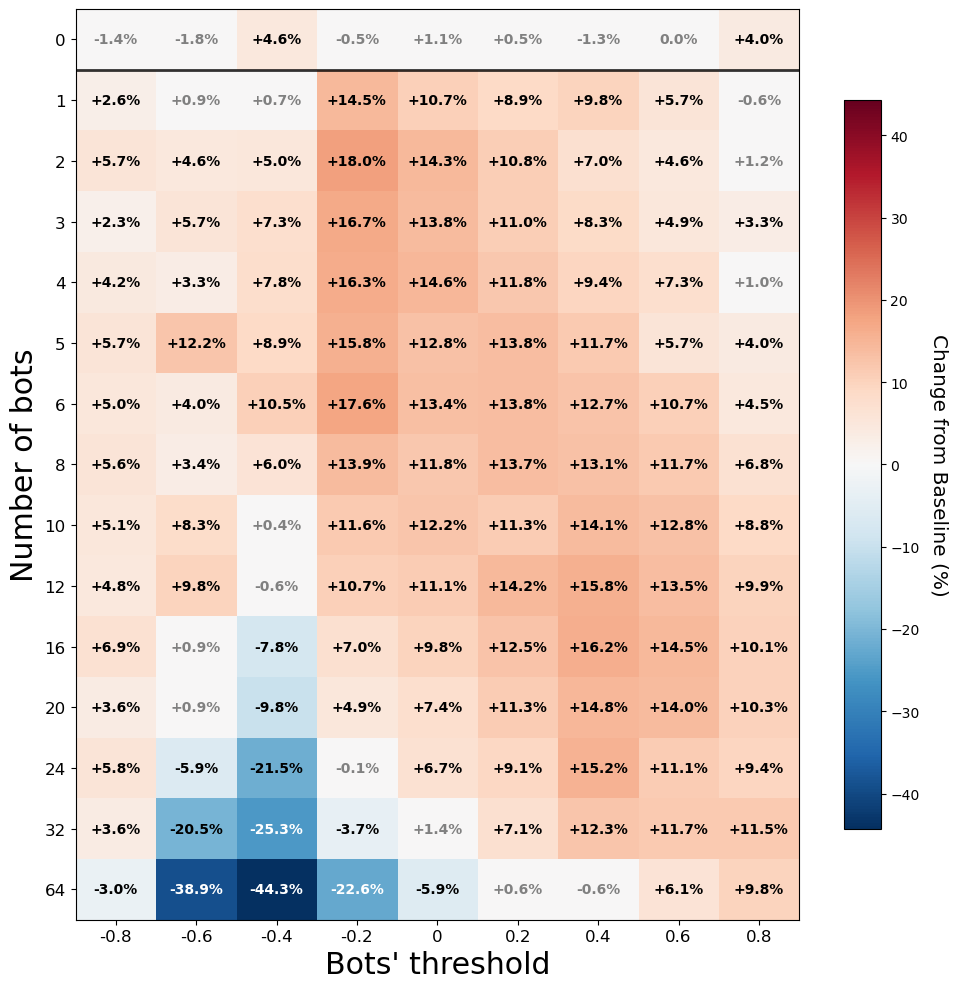

In [244]:
fig, ax, RM, base, boh = plot_epidemic_heatmap_relative(bot_data_1000, 
                 param1_values=[-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8], 
                 param2_values= [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 32, 64],
                 param1_name="th", param2_name="nb", param1_is_rows=False, figsize=(10, 10), title = None, ylabel = "Number of bots", xlabel = "Bots' threshold", fontsize = 12)


fig.savefig("SIR_1000_heatmap.pdf", dpi=300, bbox_inches='tight')

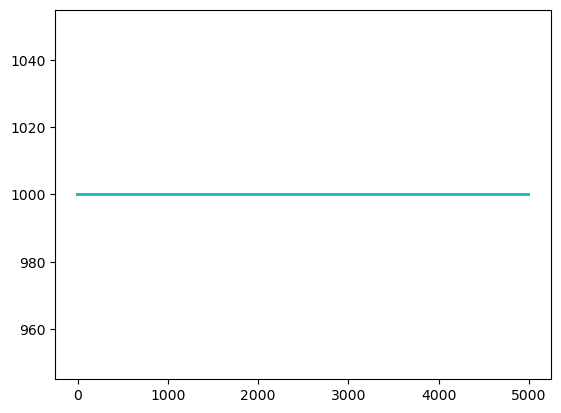

In [253]:
temp = bot_data_1000_SIRV[(0, 16)]


S = temp["S_count"].T
I = temp["I_count"].T
R = temp["R_count"].T

plt.plot(S+I+R, label = "S")

Noise threshold (75th percentile baseline deviation): ±3.2%


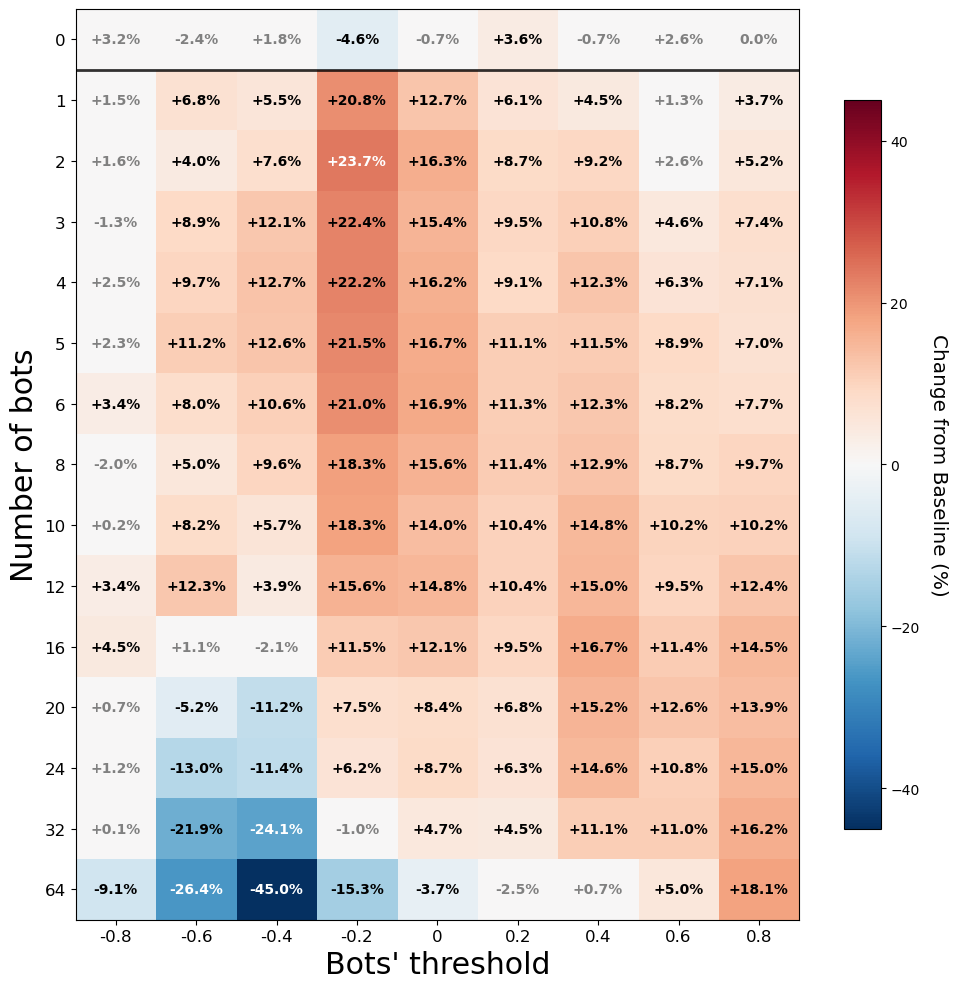

In [249]:
fig, ax, RM, base,boh = plot_epidemic_heatmap_relative(bot_data_1000_SIRV, 
                 param1_values=[-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8], 
                 param2_values= [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 32, 64],
                 param1_name="th", param2_name="nb", param1_is_rows=False, figsize=(10, 10), title = None, ylabel = "Number of bots", xlabel = "Bots' threshold", fontsize = 12)

fig.savefig("SIRV_1000_heatmap.pdf", dpi=300, bbox_inches="tight")

In [250]:
data_with_bots = load_simulation_data(
    data_dir=r"C:\Users\nel_t\Documents\WORK\PROJECTS\Boosting Bots\data\09_07_25\300_100_discrete",
    file_pattern="results_ce*_th*_nb*",  # Include all 3 params
    param_names=["ce", "th", "nb"],      # Use all 3 param names
    date_suffix=None
)
bot_data_1000 = {(th, nb): data for (ce, th, nb), data in data_with_bots.items()}

Loaded: ce=0.2, th=-0.2, nb=0.0
Loaded: ce=0.2, th=-0.2, nb=10.0
Loaded: ce=0.2, th=-0.2, nb=12.0
Loaded: ce=0.2, th=-0.2, nb=16.0
Loaded: ce=0.2, th=-0.2, nb=1.0
Loaded: ce=0.2, th=-0.2, nb=20.0
Loaded: ce=0.2, th=-0.2, nb=24.0
Loaded: ce=0.2, th=-0.2, nb=2.0
Loaded: ce=0.2, th=-0.2, nb=32.0
Loaded: ce=0.2, th=-0.2, nb=3.0
Loaded: ce=0.2, th=-0.2, nb=4.0
Loaded: ce=0.2, th=-0.2, nb=5.0
Loaded: ce=0.2, th=-0.2, nb=64.0
Loaded: ce=0.2, th=-0.2, nb=6.0
Loaded: ce=0.2, th=-0.2, nb=8.0
Loaded: ce=0.2, th=-0.4, nb=0.0
Loaded: ce=0.2, th=-0.4, nb=10.0
Loaded: ce=0.2, th=-0.4, nb=12.0
Loaded: ce=0.2, th=-0.4, nb=16.0
Loaded: ce=0.2, th=-0.4, nb=1.0
Loaded: ce=0.2, th=-0.4, nb=20.0
Loaded: ce=0.2, th=-0.4, nb=24.0
Loaded: ce=0.2, th=-0.4, nb=2.0
Loaded: ce=0.2, th=-0.4, nb=32.0
Loaded: ce=0.2, th=-0.4, nb=3.0
Loaded: ce=0.2, th=-0.4, nb=4.0
Loaded: ce=0.2, th=-0.4, nb=5.0
Loaded: ce=0.2, th=-0.4, nb=64.0
Loaded: ce=0.2, th=-0.4, nb=6.0
Loaded: ce=0.2, th=-0.4, nb=8.0
Loaded: ce=0.2, th=-0.6, n

In [12]:
data_with_bots = load_simulation_data(
    data_dir=r"C:\Users\nel_t\Documents\WORK\PROJECTS\Boosting Bots\data\09_07_25\No_bots_sigma_experiment",
    file_pattern="results_ce*_th*_nb*",  # Include all 3 params
    param_names=["ce", "th", "nb"],      # Use all 3 param names
    date_suffix=None
)
data_no_bots = {(ce, nb): data for (ce, th, nb), data in data_with_bots.items()}

Loaded: ce=0.05, th=0.0, nb=0.0
Loaded: ce=0.15, th=0.0, nb=0.0
Loaded: ce=0.1, th=0.0, nb=0.0
Loaded: ce=0.25, th=0.0, nb=0.0
Loaded: ce=0.2, th=0.0, nb=0.0
Loaded: ce=0.35, th=0.0, nb=0.0
Loaded: ce=0.3, th=0.0, nb=0.0
Loaded: ce=0.45, th=0.0, nb=0.0
Loaded: ce=0.4, th=0.0, nb=0.0
Loaded: ce=0.5, th=0.0, nb=0.0
Loaded: ce=0.0, th=0.0, nb=0.0

Loaded 11 files total


In [24]:
nobots_meanvar = load_simulation_data(
    data_dir=r"C:\Users\nel_t\Documents\WORK\PROJECTS\Boosting Bots\data\09_07_25\IC_consensus",
    file_pattern="results_mean*_var*",  # Include all 3 params
    param_names=["mean", "var"],      # Use all 3 param names
    date_suffix=None
)
data_no_bots = {(mean, var): data for (mean, var), data in nobots_meanvar.items()}

Loaded: mean=-0.1, var=0.01
Loaded: mean=-0.1, var=0.05
Loaded: mean=-0.1, var=0.1
Loaded: mean=-0.1, var=0.2
Loaded: mean=-0.1, var=0.5
Loaded: mean=-0.2, var=0.01
Loaded: mean=-0.2, var=0.05
Loaded: mean=-0.2, var=0.1
Loaded: mean=-0.2, var=0.2
Loaded: mean=-0.2, var=0.5
Loaded: mean=-0.3, var=0.01
Loaded: mean=-0.3, var=0.05
Loaded: mean=-0.3, var=0.1
Loaded: mean=-0.3, var=0.2
Loaded: mean=-0.3, var=0.5
Loaded: mean=-0.4, var=0.01
Loaded: mean=-0.4, var=0.05
Loaded: mean=-0.4, var=0.1
Loaded: mean=-0.4, var=0.2
Loaded: mean=-0.4, var=0.5
Loaded: mean=-0.5, var=0.01
Loaded: mean=-0.5, var=0.05
Loaded: mean=-0.5, var=0.1
Loaded: mean=-0.5, var=0.2
Loaded: mean=-0.5, var=0.5
Loaded: mean=-0.8, var=0.01
Loaded: mean=-0.8, var=0.05
Loaded: mean=-0.8, var=0.1
Loaded: mean=-0.8, var=0.2
Loaded: mean=-0.8, var=0.5
Loaded: mean=-0.9, var=0.01
Loaded: mean=-0.9, var=0.05
Loaded: mean=-0.9, var=0.1
Loaded: mean=-0.9, var=0.2
Loaded: mean=-0.9, var=0.5
Loaded: mean=-1.0, var=0.01
Loaded: mean=

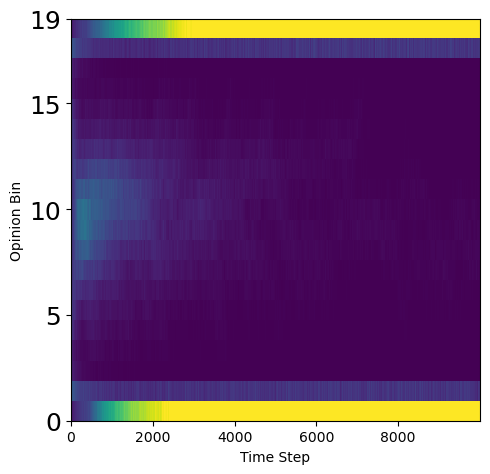

(<Figure size 500x500 with 1 Axes>,
 [[<Axes: xlabel='Time Step', ylabel='Opinion Bin'>]])

In [104]:
plot_heatmap_grid(data_no_bots, 
                 param1_values=[0.5], 
                 param2_values= [0],
                 param1_name="ce", 
                 param2_name="nb", 
                 param1_is_rows=False, 
                 figsize=(5, 5),
                 title = None,
                 yticks = [-1, -0.5, 0, 0.5, 1])

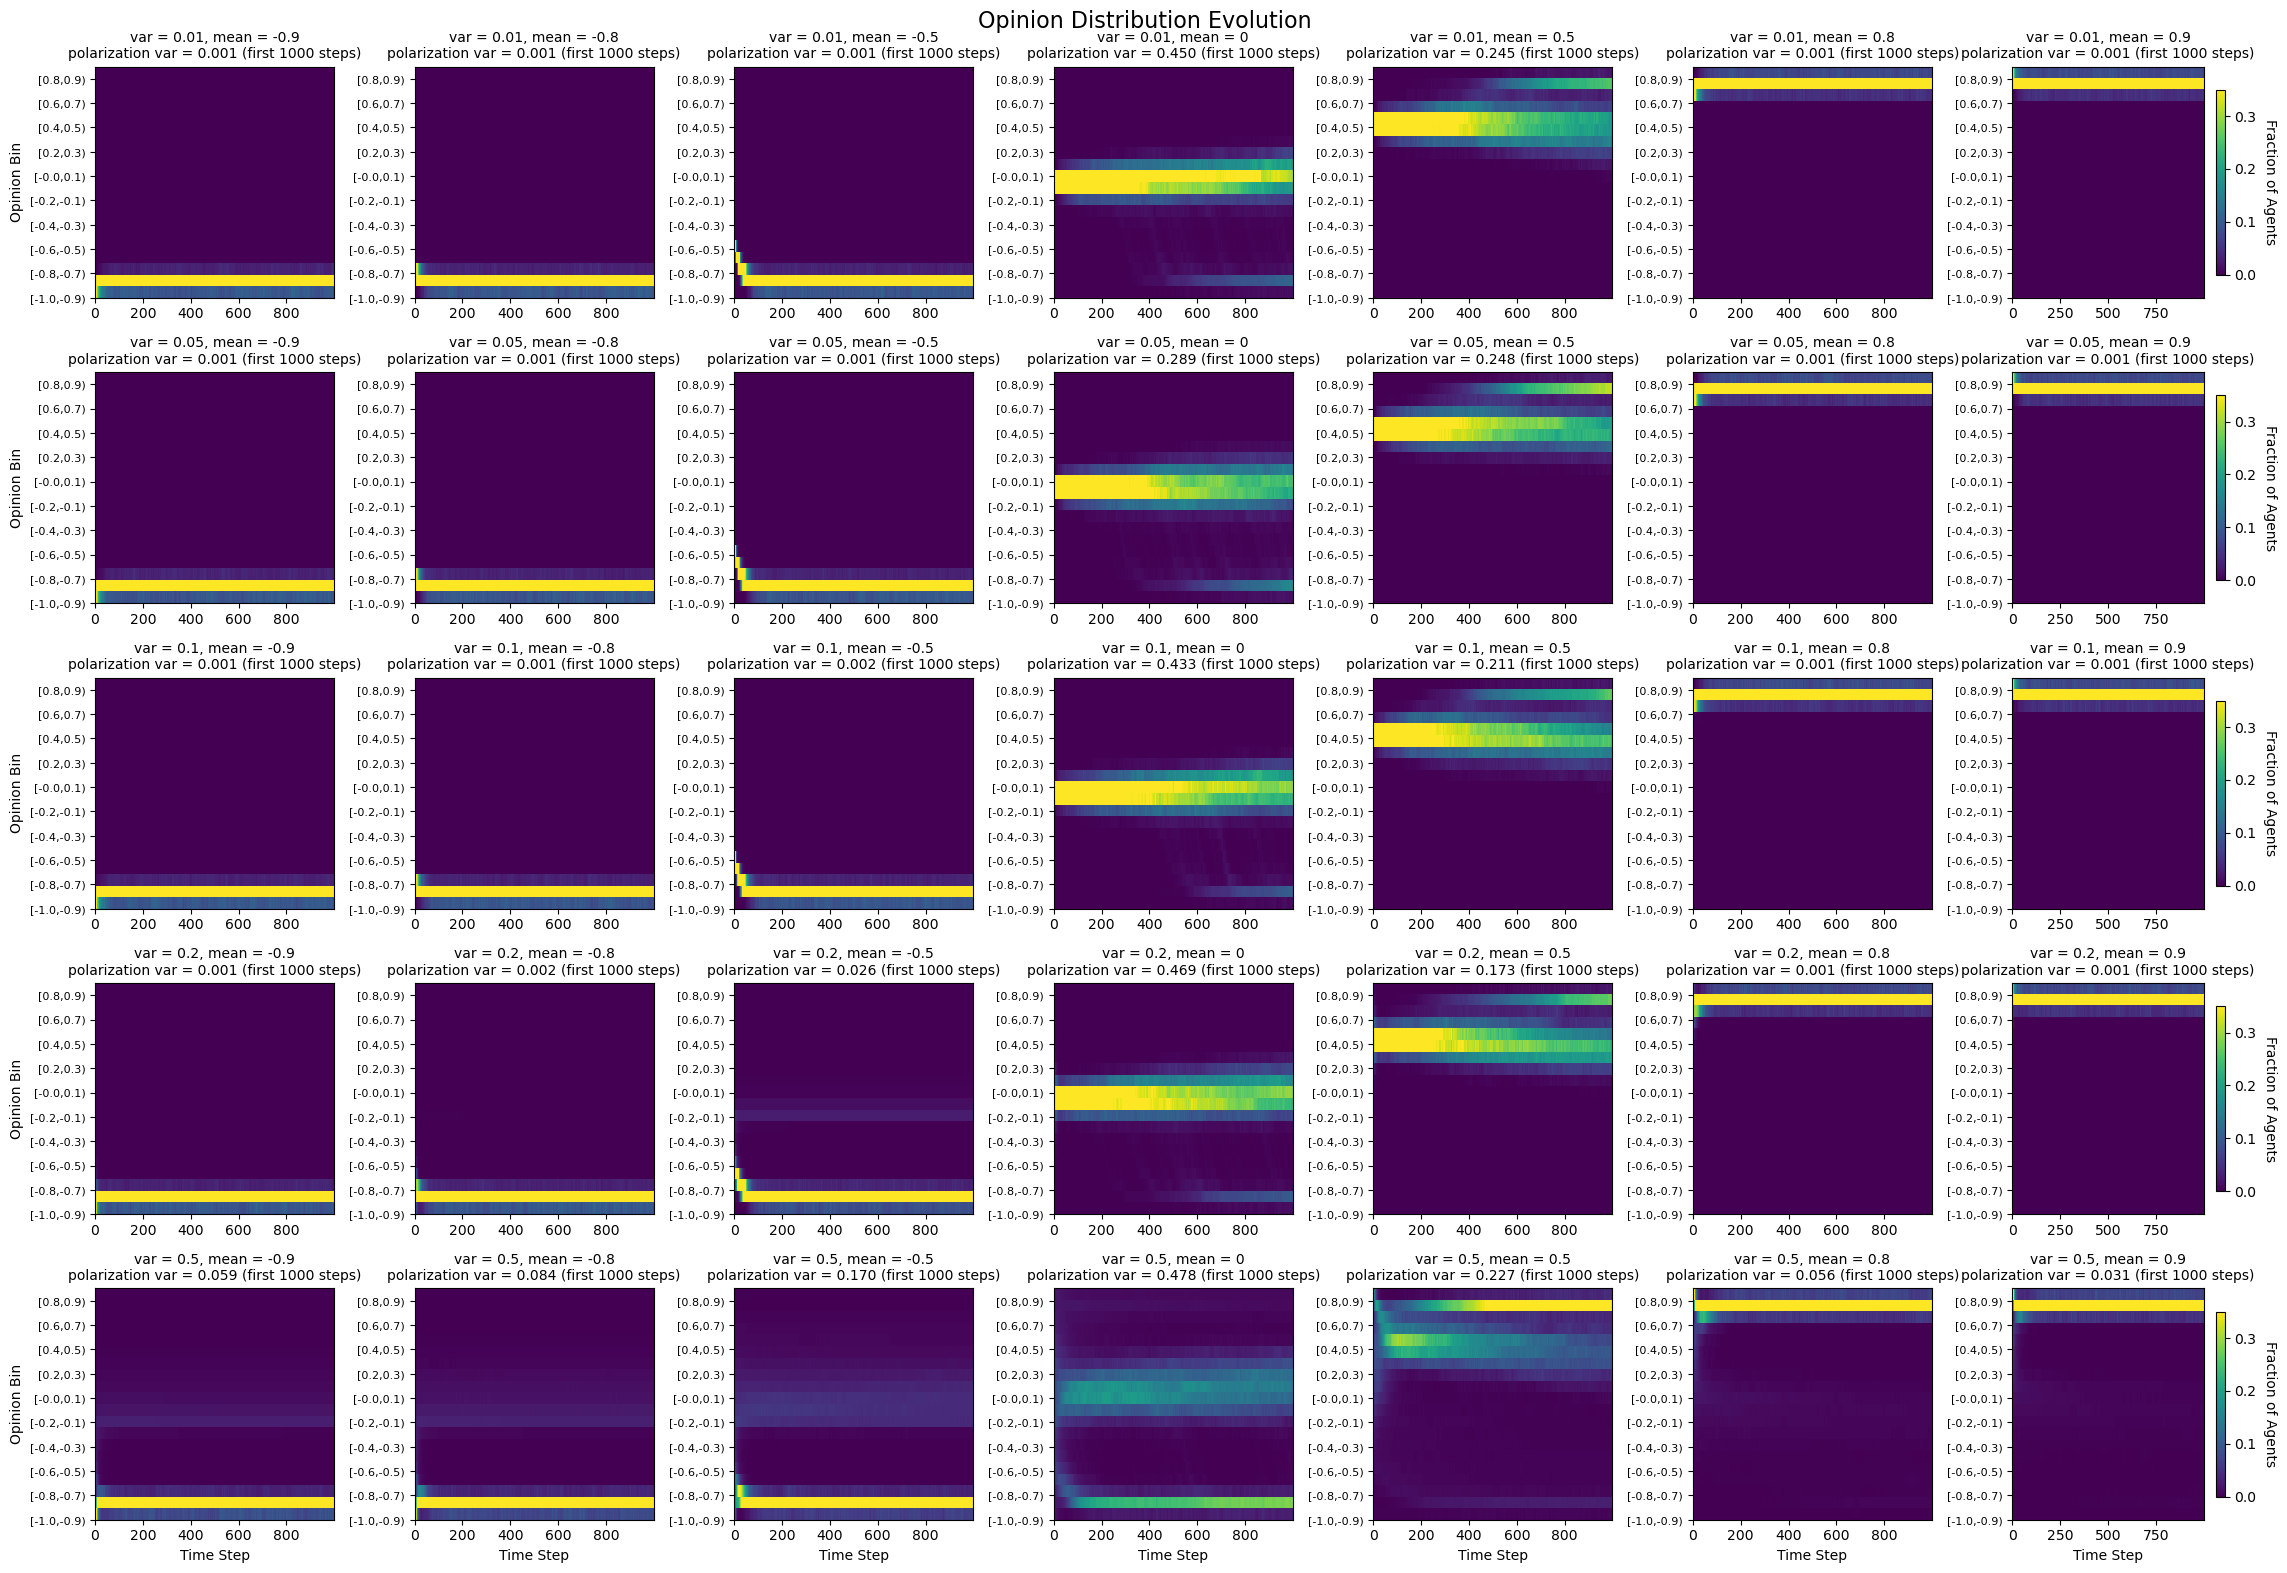

(<Figure size 2300x1600 with 40 Axes>,
 array([[<Axes: title={'center': 'var = 0.01, mean = -0.9\npolarization var = 0.001 (first 1000 steps)'}, ylabel='Opinion Bin'>,
         <Axes: title={'center': 'var = 0.01, mean = -0.8\npolarization var = 0.001 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.5\npolarization var = 0.001 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = 0\npolarization var = 0.450 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = 0.5\npolarization var = 0.245 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = 0.8\npolarization var = 0.001 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = 0.9\npolarization var = 0.001 (first 1000 steps)'}>],
        [<Axes: title={'center': 'var = 0.05, mean = -0.9\npolarization var = 0.001 (first 1000 steps)'}, ylabel='Opinion Bin'>,
         <Axes: title={'center': 'var = 0.05, mean = -0.8\npolariz

In [26]:
plot_heatmap_grid(nobots_meanvar, 
                 param1_values=[-0.9, -0.8, -0.5, 0, 0.5, 0.8, 0.9], 
                 param2_values= [0.01, 0.05, 0.1, 0.2, 0.5],
                 param1_name="mean", param2_name="var", param1_is_rows=False, max_time_steps=1000)

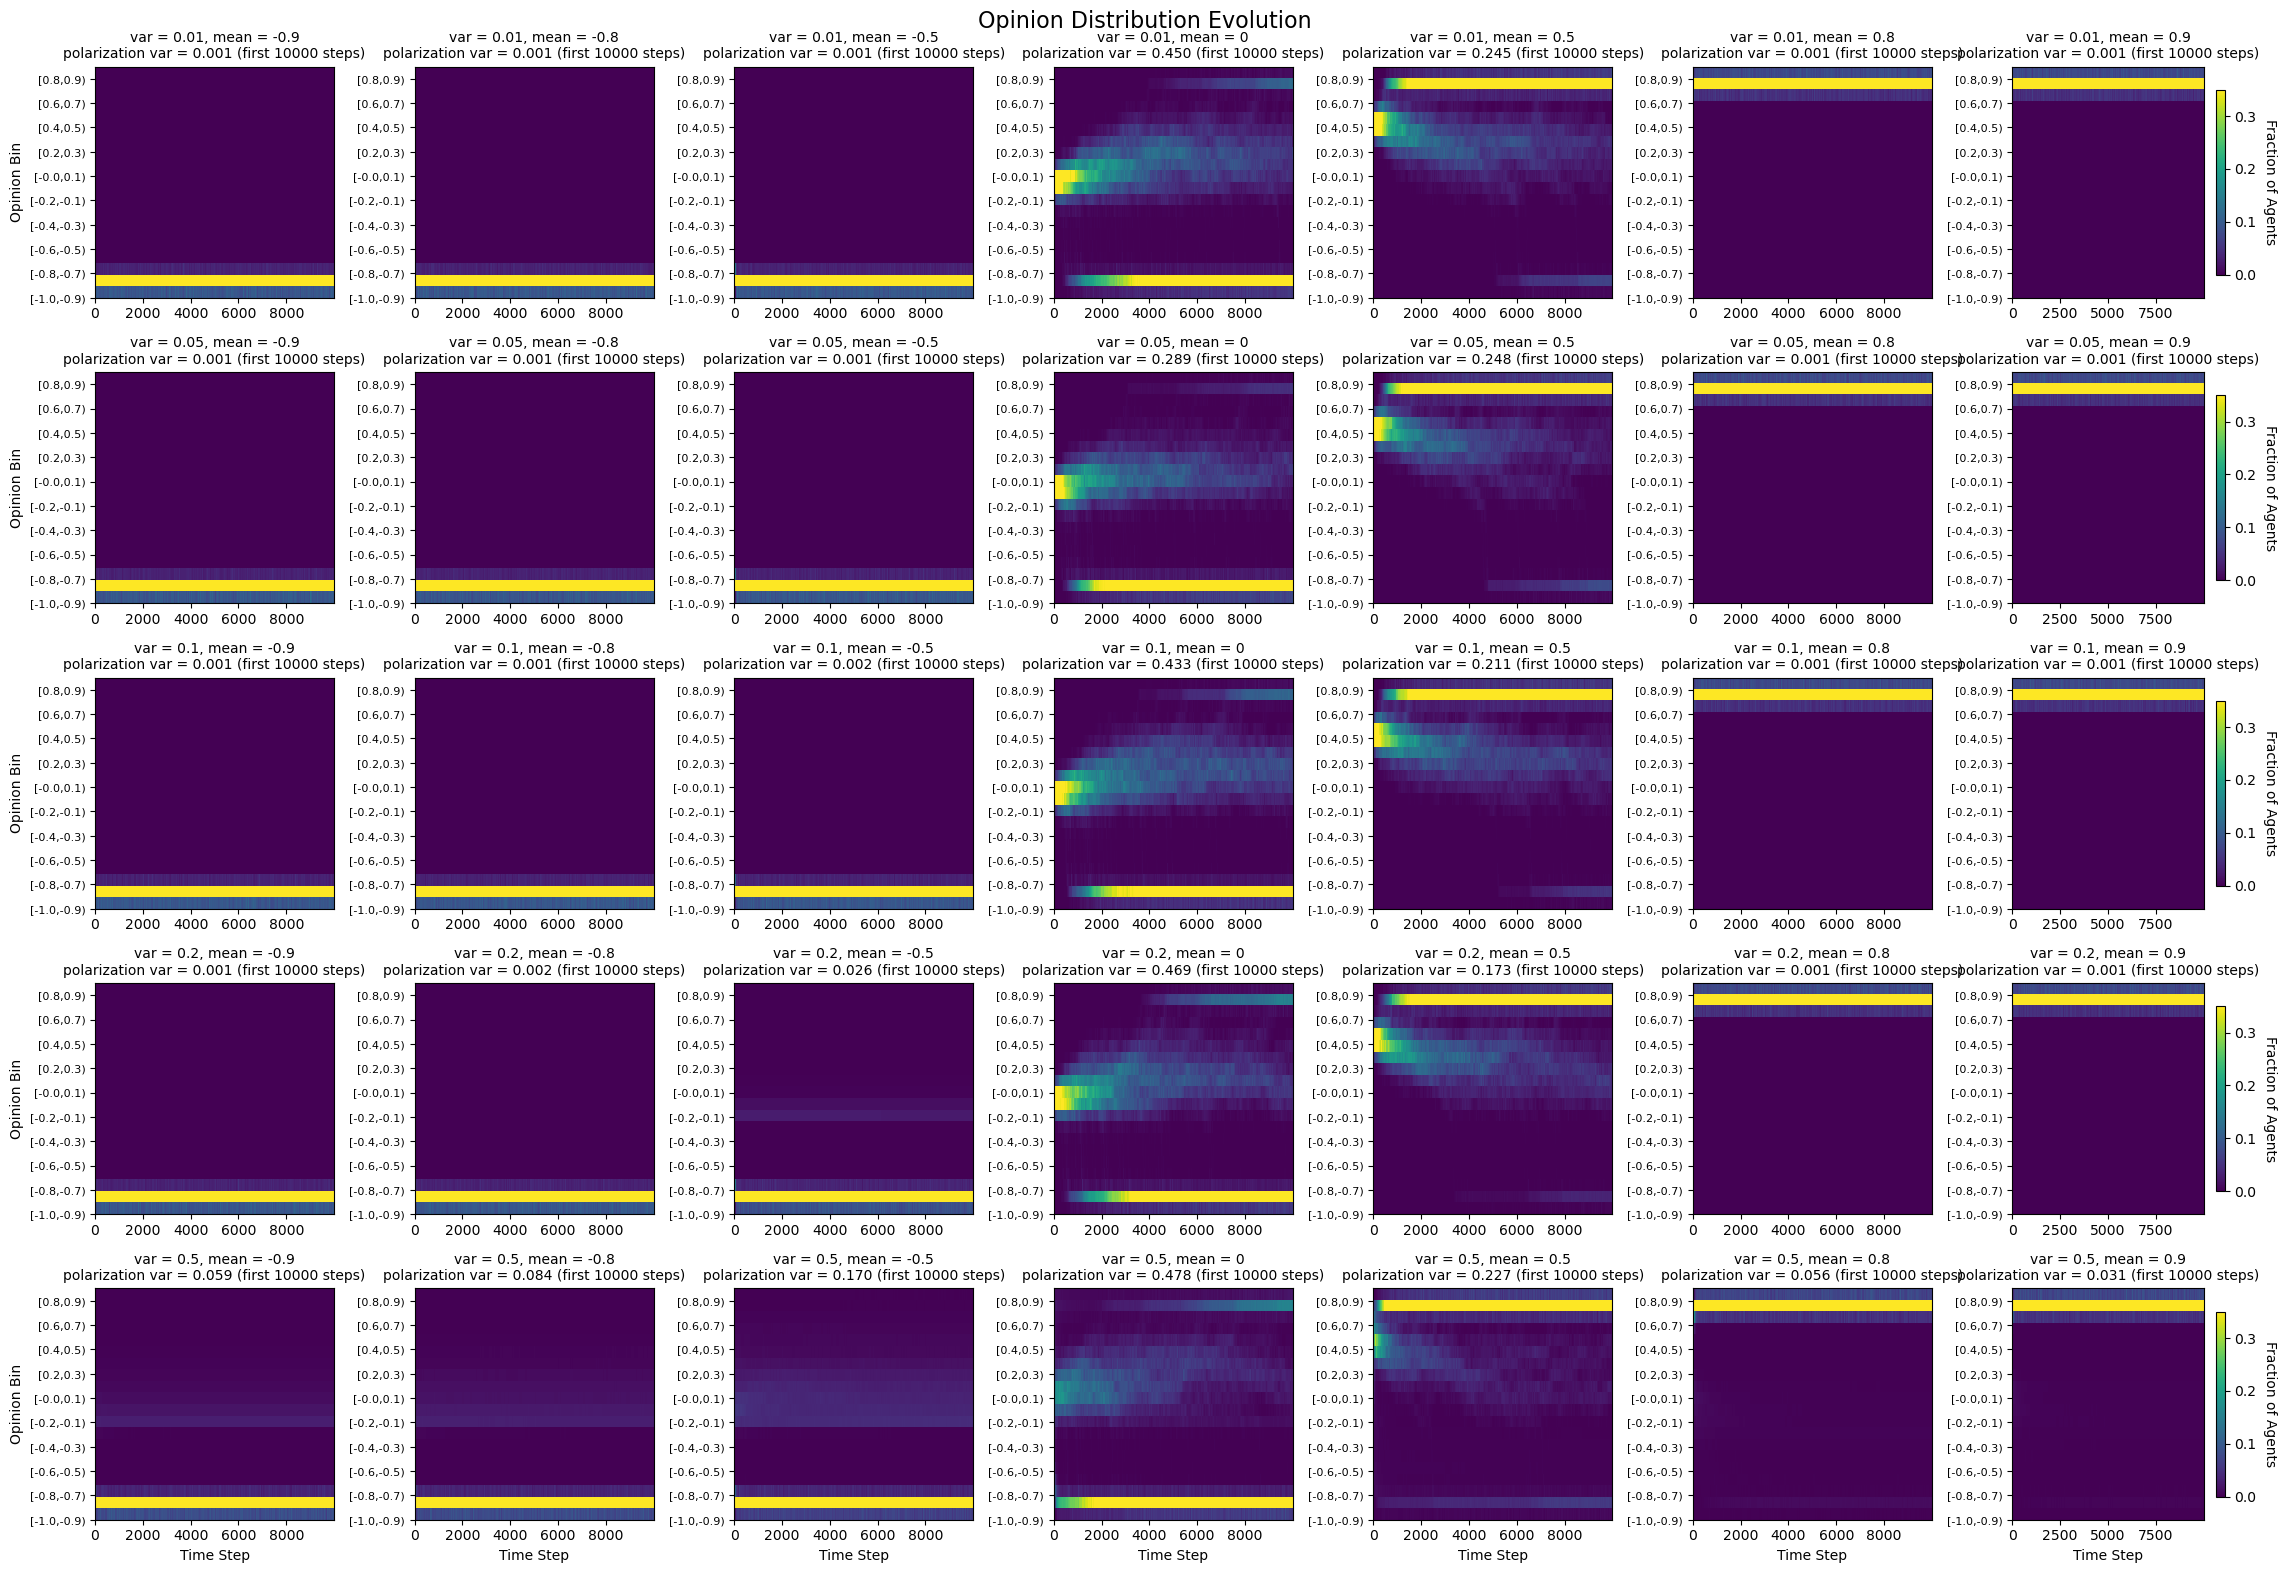

(<Figure size 2300x1600 with 40 Axes>,
 array([[<Axes: title={'center': 'var = 0.01, mean = -0.9\npolarization var = 0.001 (first 10000 steps)'}, ylabel='Opinion Bin'>,
         <Axes: title={'center': 'var = 0.01, mean = -0.8\npolarization var = 0.001 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.5\npolarization var = 0.001 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = 0\npolarization var = 0.450 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = 0.5\npolarization var = 0.245 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = 0.8\npolarization var = 0.001 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = 0.9\npolarization var = 0.001 (first 10000 steps)'}>],
        [<Axes: title={'center': 'var = 0.05, mean = -0.9\npolarization var = 0.001 (first 10000 steps)'}, ylabel='Opinion Bin'>,
         <Axes: title={'center': 'var = 0.05, mean = -0.8\

In [25]:
plot_heatmap_grid(nobots_meanvar, 
                 param1_values=[-0.9, -0.8, -0.5, 0, 0.5, 0.8, 0.9], 
                 param2_values= [0.01, 0.05, 0.1, 0.2, 0.5],
                 param1_name="mean", param2_name="var", param1_is_rows=False, max_time_steps=10000)

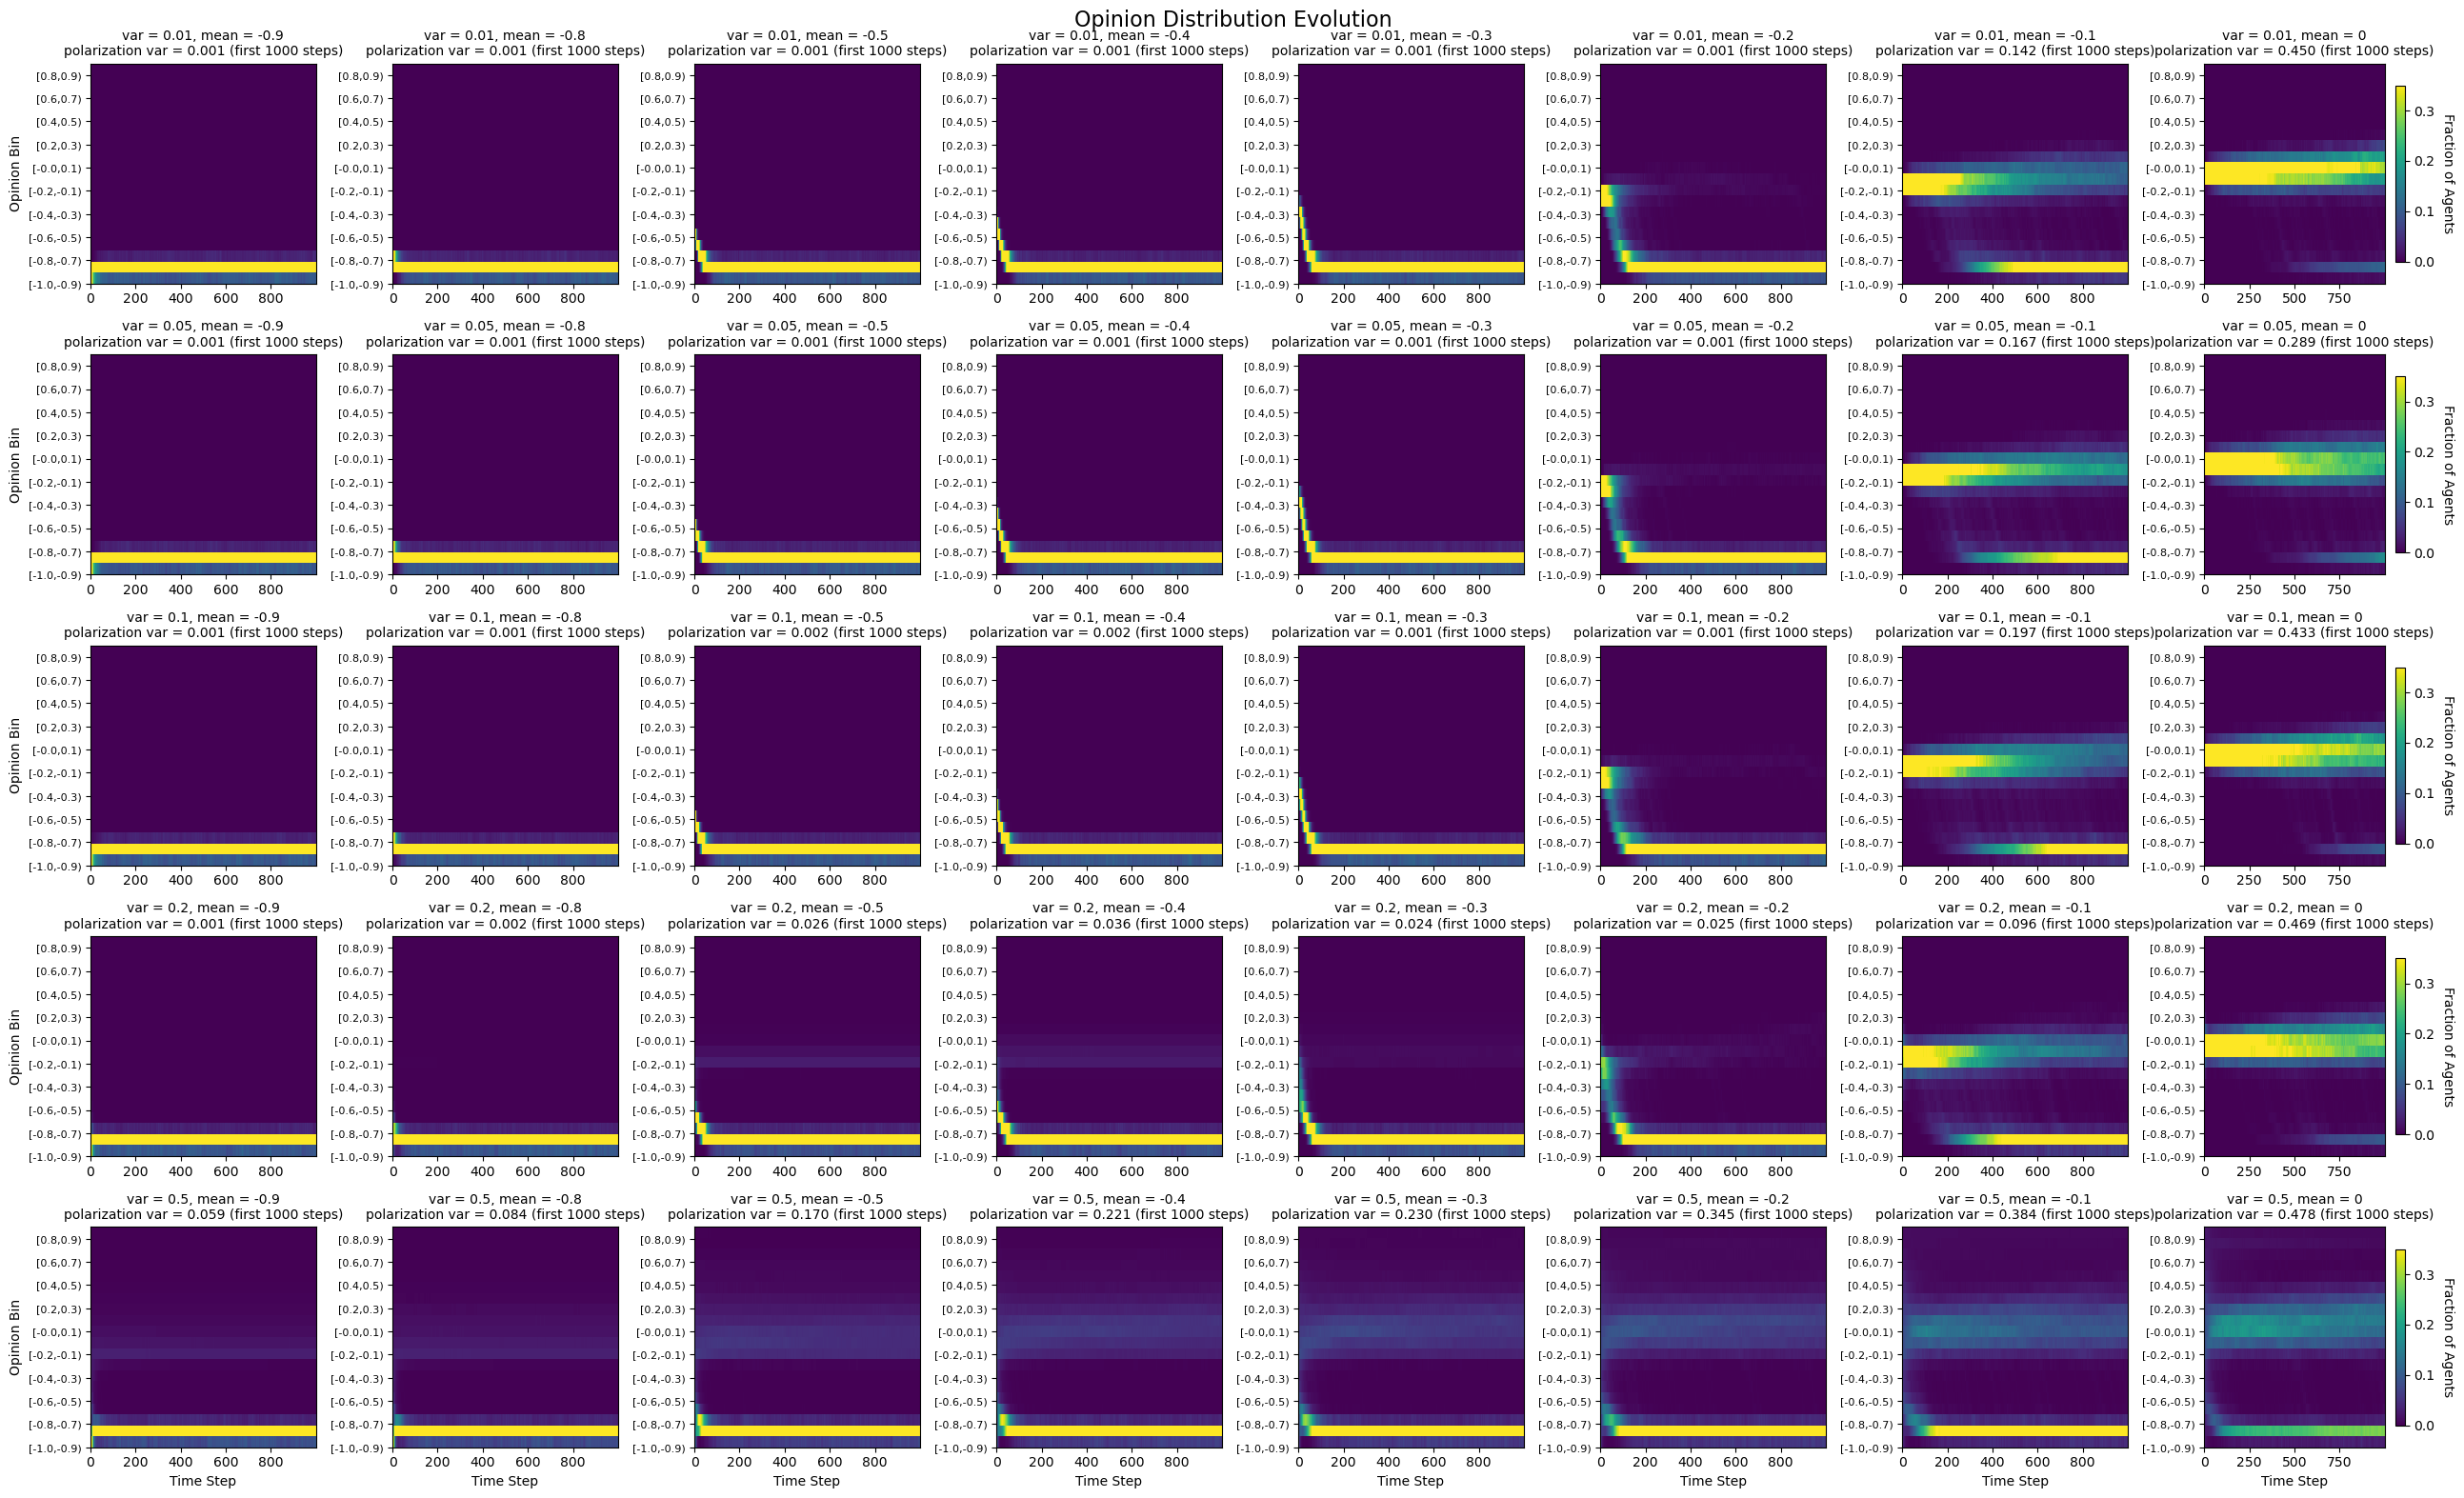

(<Figure size 2600x1600 with 45 Axes>,
 array([[<Axes: title={'center': 'var = 0.01, mean = -0.9\npolarization var = 0.001 (first 1000 steps)'}, ylabel='Opinion Bin'>,
         <Axes: title={'center': 'var = 0.01, mean = -0.8\npolarization var = 0.001 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.5\npolarization var = 0.001 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.4\npolarization var = 0.001 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.3\npolarization var = 0.001 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.2\npolarization var = 0.001 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.1\npolarization var = 0.142 (first 1000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = 0\npolarization var = 0.450 (first 1000 steps)'}>],
        [<Axes: title={'center': 'var = 0.05, mean = -0.9\npolarization var = 0.001 (

In [31]:
plot_heatmap_grid(nobots_meanvar, 
                 param1_values=[-0.9, -0.8, -0.5, -0.4, -0.3, -0.2, -0.1, 0], 
                 param2_values= [0.01, 0.05, 0.1, 0.2, 0.5],
                 param1_name="mean", param2_name="var", param1_is_rows=False, max_time_steps=1000)

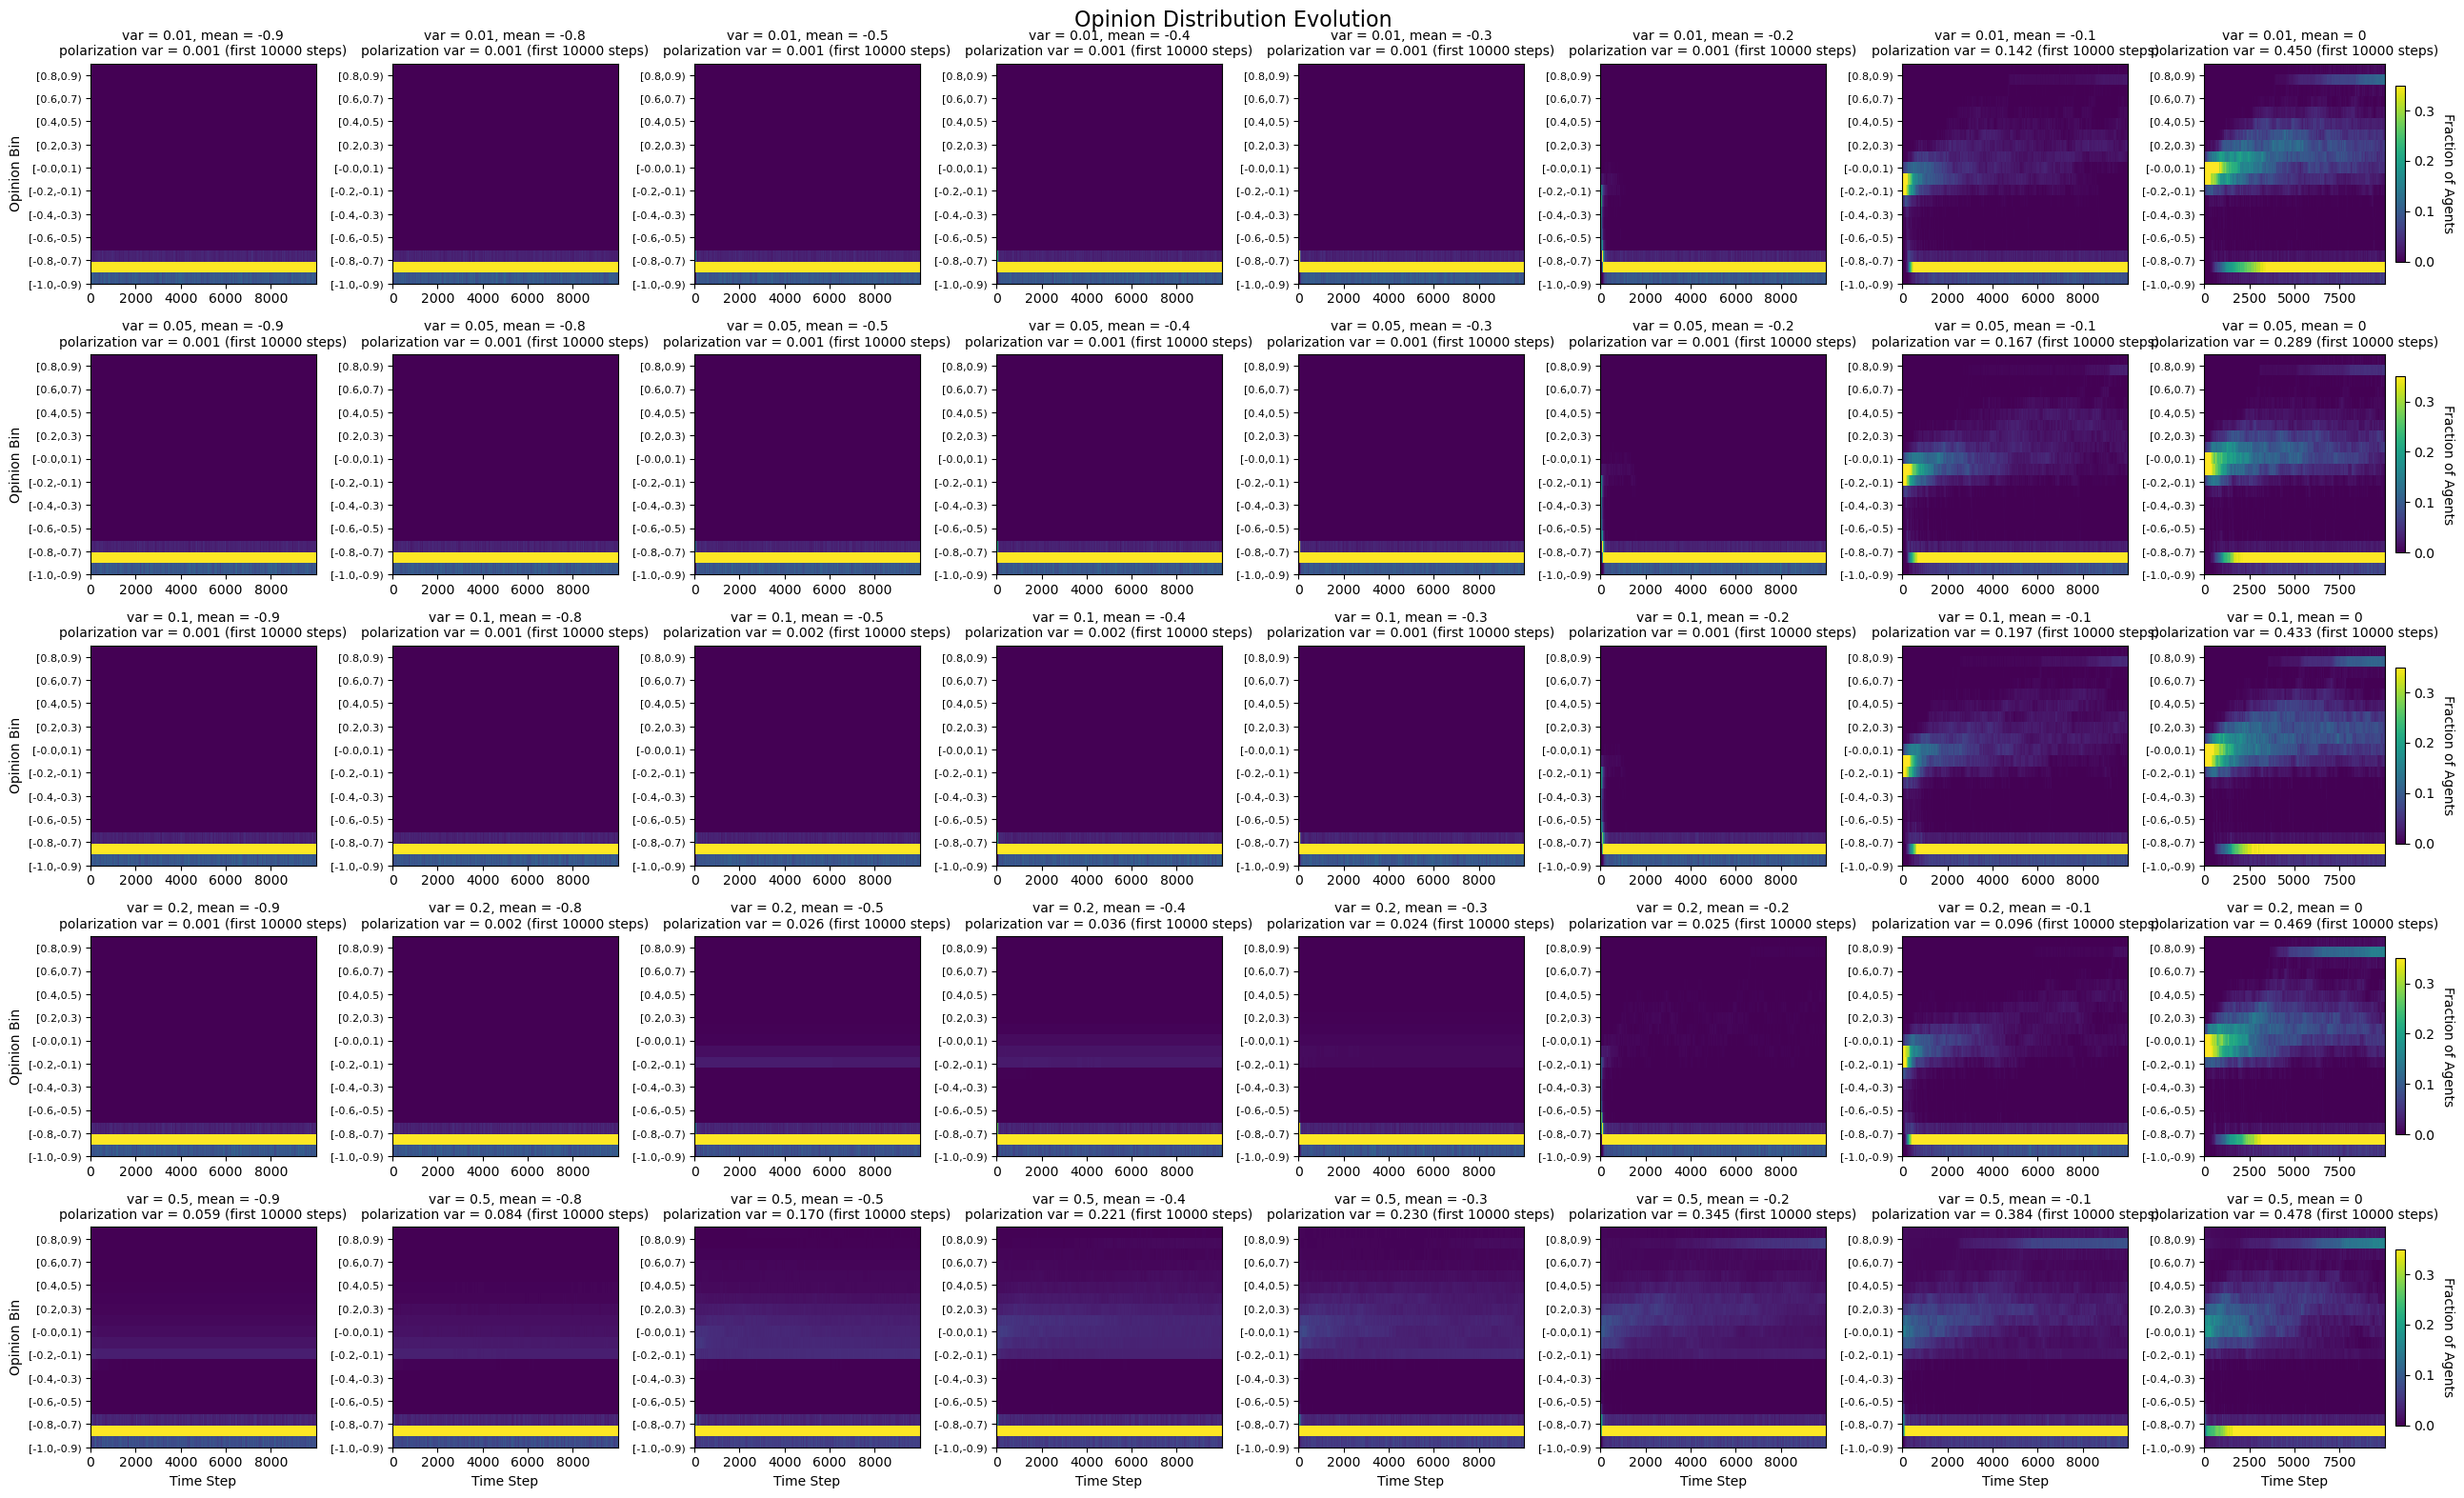

(<Figure size 2600x1600 with 45 Axes>,
 array([[<Axes: title={'center': 'var = 0.01, mean = -0.9\npolarization var = 0.001 (first 10000 steps)'}, ylabel='Opinion Bin'>,
         <Axes: title={'center': 'var = 0.01, mean = -0.8\npolarization var = 0.001 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.5\npolarization var = 0.001 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.4\npolarization var = 0.001 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.3\npolarization var = 0.001 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.2\npolarization var = 0.001 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = -0.1\npolarization var = 0.142 (first 10000 steps)'}>,
         <Axes: title={'center': 'var = 0.01, mean = 0\npolarization var = 0.450 (first 10000 steps)'}>],
        [<Axes: title={'center': 'var = 0.05, mean = -0.9\npolarization var =

In [32]:
plot_heatmap_grid(nobots_meanvar, 
                 param1_values=[-0.9, -0.8, -0.5, -0.4, -0.3, -0.2, -0.1, 0], 
                 param2_values= [0.01, 0.05, 0.1, 0.2, 0.5],
                 param1_name="mean", param2_name="var", param1_is_rows=False, max_time_steps=10000)

In [ ]:
data_no_bots[]

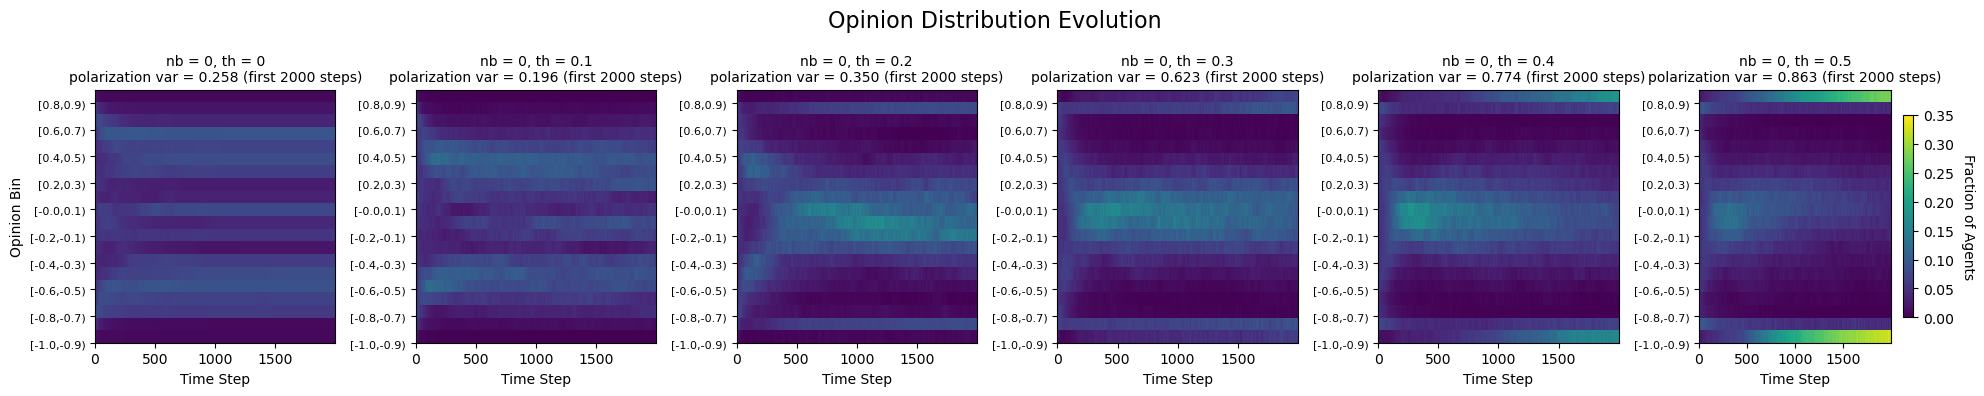

(<Figure size 2000x400 with 7 Axes>,
 [array([<Axes: title={'center': 'nb = 0, th = 0\npolarization var = 0.258 (first 2000 steps)'}, xlabel='Time Step', ylabel='Opinion Bin'>,
         <Axes: title={'center': 'nb = 0, th = 0.1\npolarization var = 0.196 (first 2000 steps)'}, xlabel='Time Step'>,
         <Axes: title={'center': 'nb = 0, th = 0.2\npolarization var = 0.350 (first 2000 steps)'}, xlabel='Time Step'>,
         <Axes: title={'center': 'nb = 0, th = 0.3\npolarization var = 0.623 (first 2000 steps)'}, xlabel='Time Step'>,
         <Axes: title={'center': 'nb = 0, th = 0.4\npolarization var = 0.774 (first 2000 steps)'}, xlabel='Time Step'>,
         <Axes: title={'center': 'nb = 0, th = 0.5\npolarization var = 0.863 (first 2000 steps)'}, xlabel='Time Step'>],
        dtype=object)])

In [17]:
plot_heatmap_grid(data_no_bots, 
                 param1_values=[0, 0.1,  0.2,  0.3,  0.4,  0.5], 
                 param2_values= [0],
                 param1_name="th", param2_name="nb", param1_is_rows=False, max_time_steps=2000)

In [ ]:
plot_heatmap_grid(bot_data_1000, 
                 param1_values=[-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8], 
                 param2_values= [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 32, 64],
                 param1_name="th", param2_name="nb", param1_is_rows=False, max_time_steps=2000)

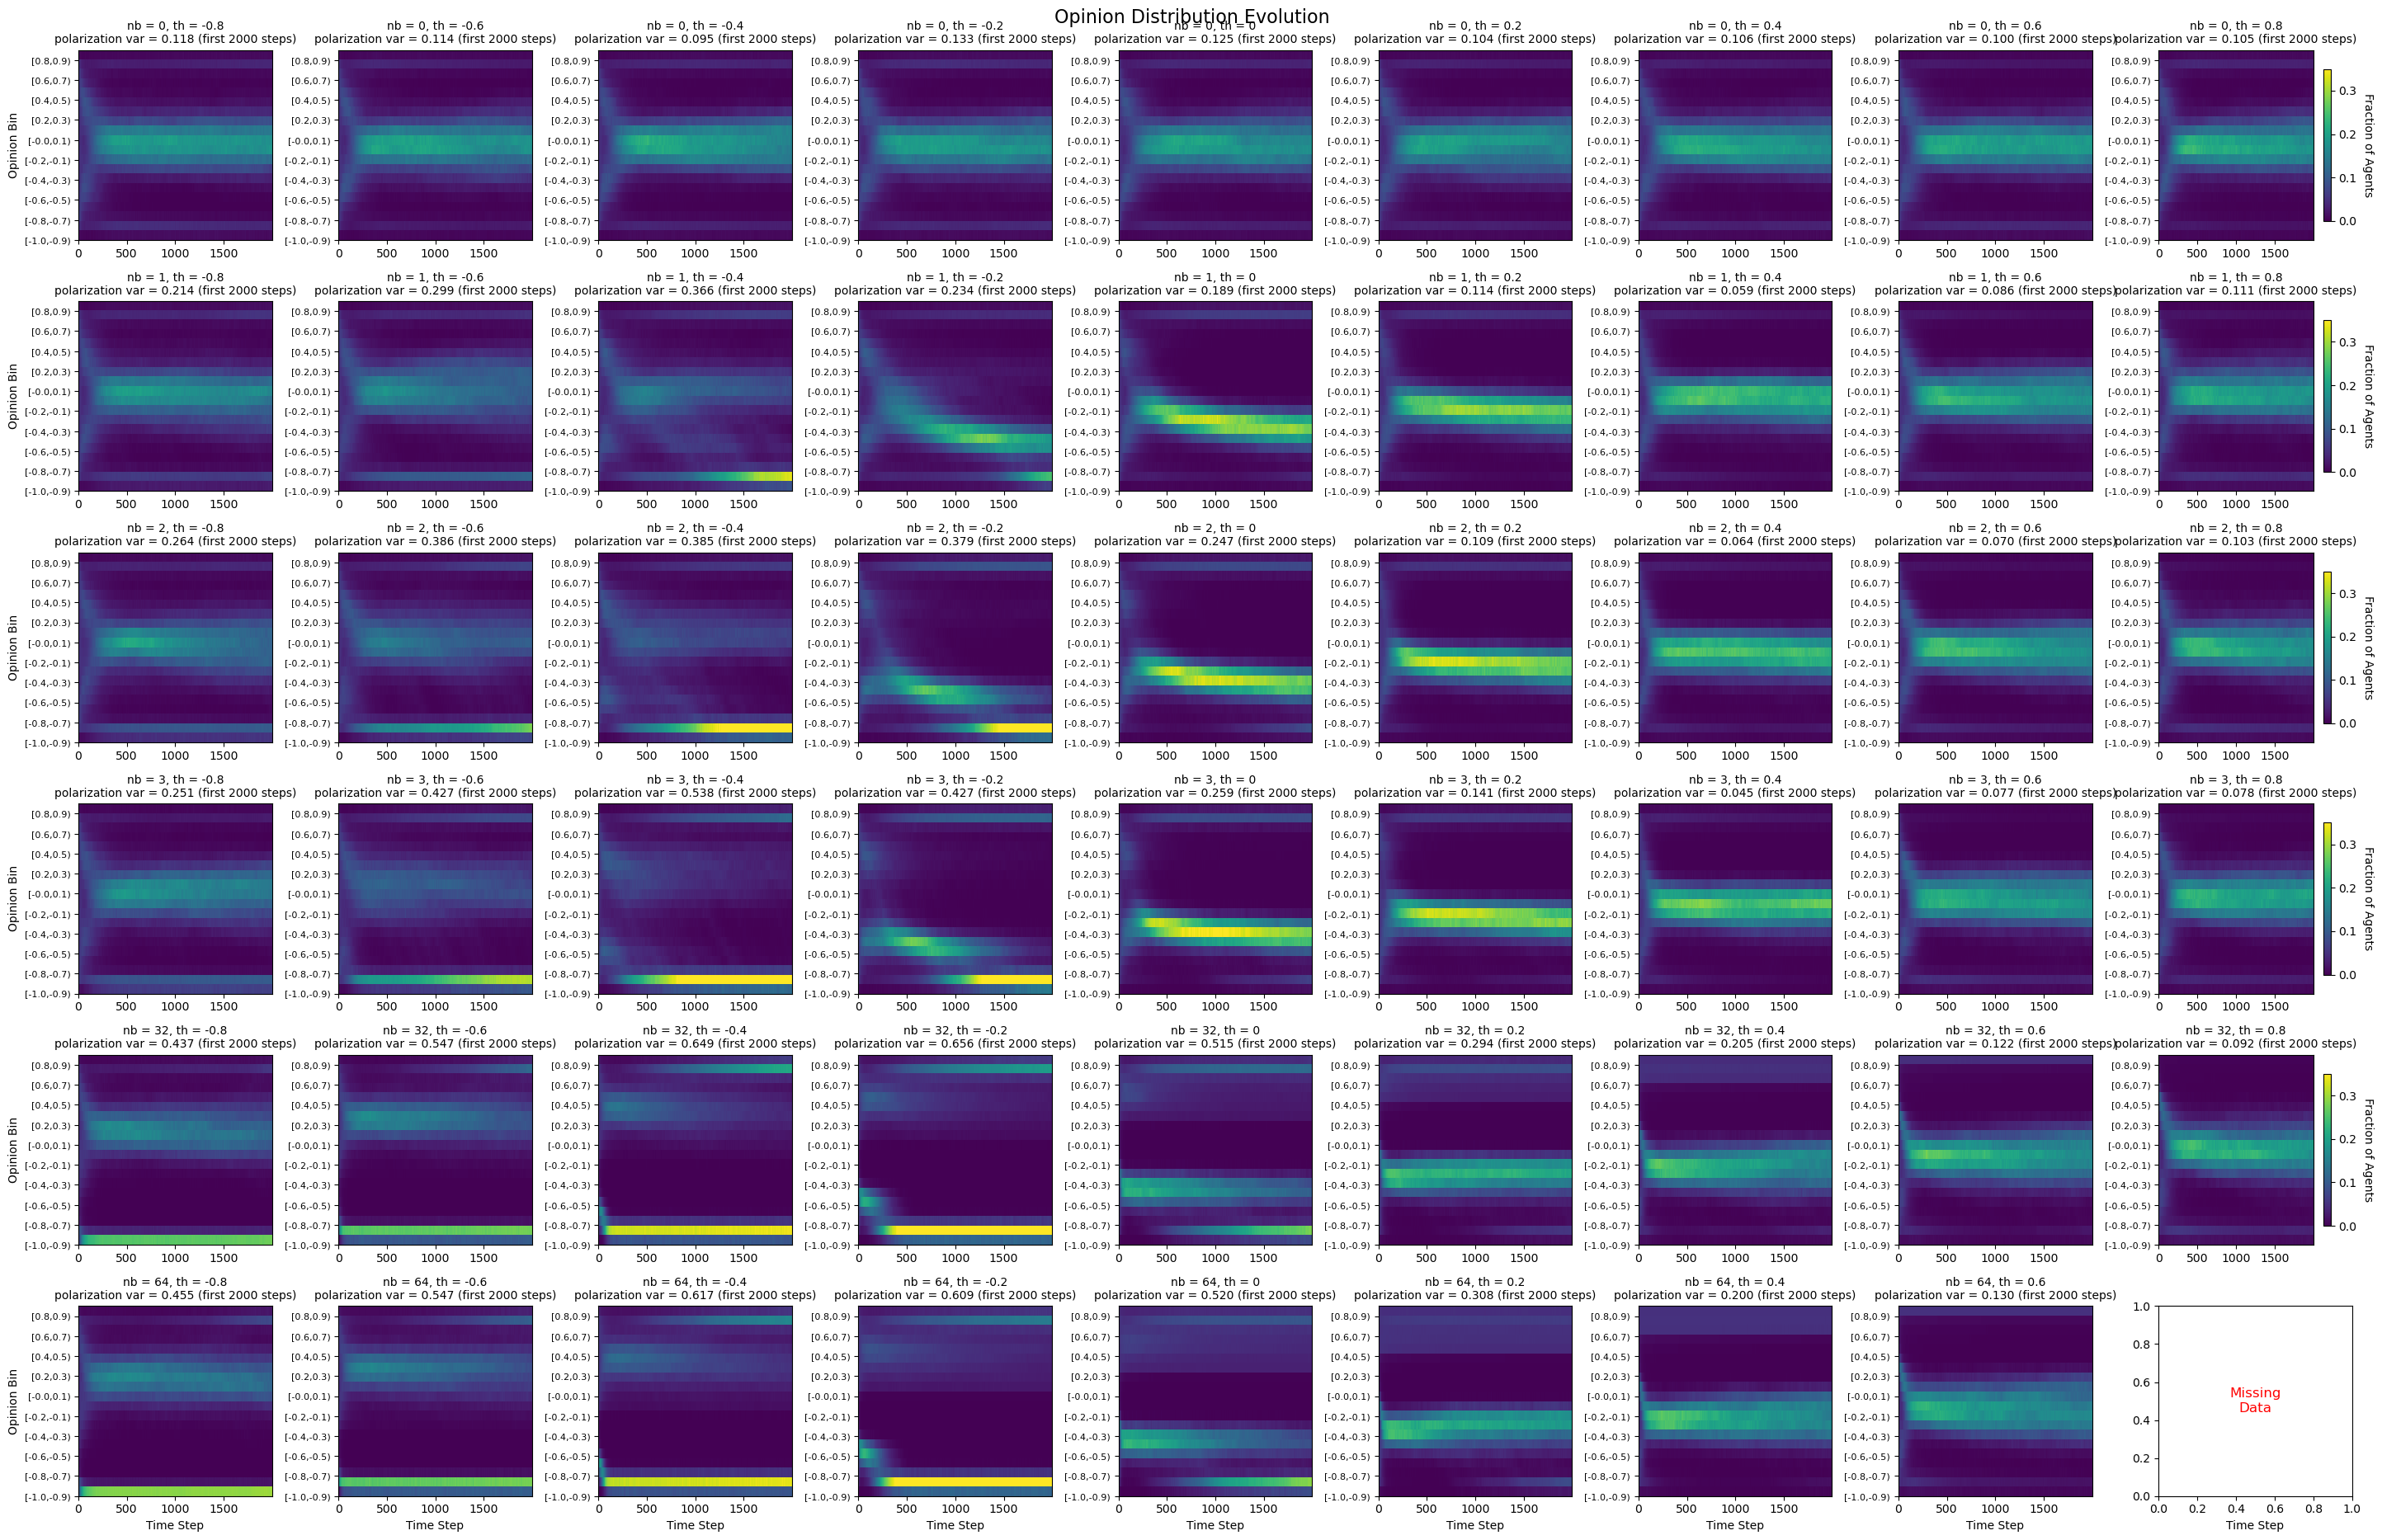

(<Figure size 2900x1900 with 59 Axes>,
 array([[<Axes: title={'center': 'nb = 0, th = -0.8\npolarization var = 0.118 (first 2000 steps)'}, ylabel='Opinion Bin'>,
         <Axes: title={'center': 'nb = 0, th = -0.6\npolarization var = 0.114 (first 2000 steps)'}>,
         <Axes: title={'center': 'nb = 0, th = -0.4\npolarization var = 0.095 (first 2000 steps)'}>,
         <Axes: title={'center': 'nb = 0, th = -0.2\npolarization var = 0.133 (first 2000 steps)'}>,
         <Axes: title={'center': 'nb = 0, th = 0\npolarization var = 0.125 (first 2000 steps)'}>,
         <Axes: title={'center': 'nb = 0, th = 0.2\npolarization var = 0.104 (first 2000 steps)'}>,
         <Axes: title={'center': 'nb = 0, th = 0.4\npolarization var = 0.106 (first 2000 steps)'}>,
         <Axes: title={'center': 'nb = 0, th = 0.6\npolarization var = 0.100 (first 2000 steps)'}>,
         <Axes: title={'center': 'nb = 0, th = 0.8\npolarization var = 0.105 (first 2000 steps)'}>],
        [<Axes: title={'center': 'nb

In [10]:
plot_heatmap_grid(bot_data_1000, 
                 param1_values=[-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8], 
                 param2_values= [0, 1, 2, 3, 32, 64],
                 param1_name="th", param2_name="nb", param1_is_rows=False, max_time_steps=2000)

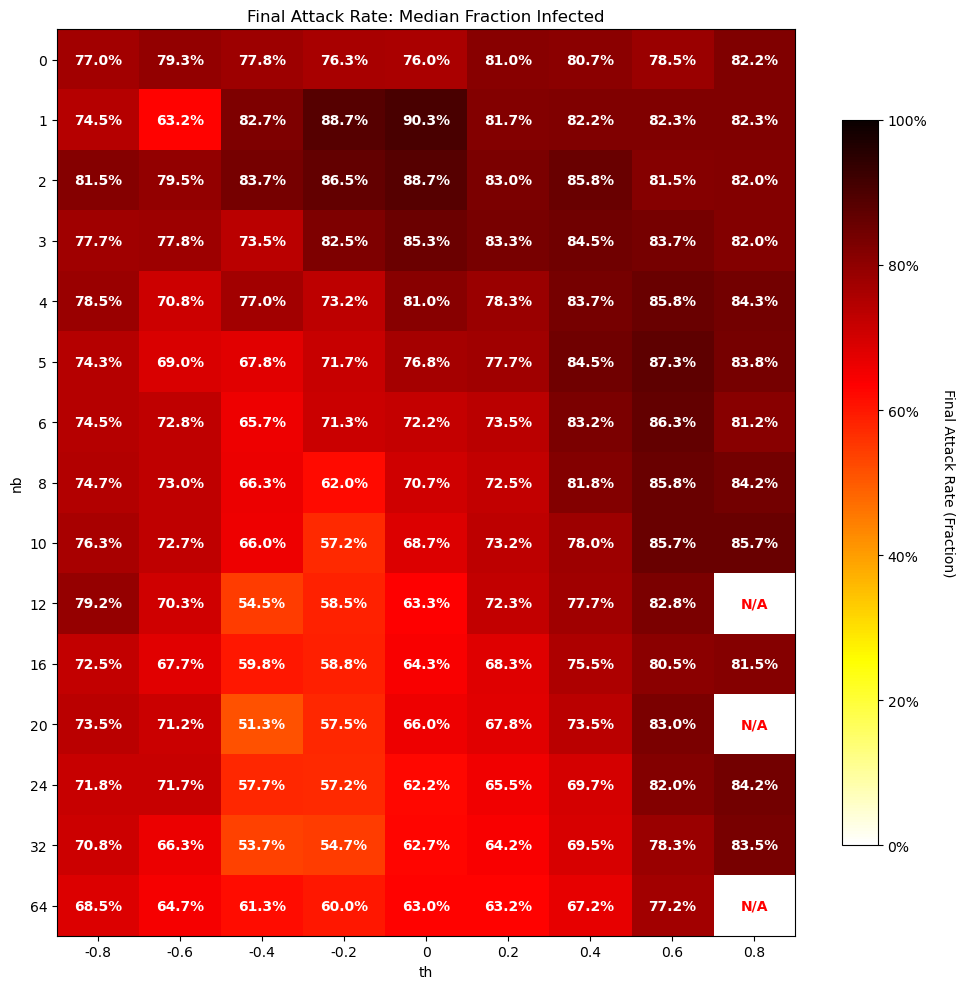

(<Figure size 1000x1000 with 2 Axes>,
 <Axes: title={'center': 'Final Attack Rate: Median Fraction Infected'}, xlabel='th', ylabel='nb'>,
 array([[0.77      , 0.79333333, 0.77833333, 0.76333333, 0.76      ,
         0.81      , 0.80666667, 0.785     , 0.82166667],
        [0.745     , 0.63166667, 0.82666667, 0.88666667, 0.90333333,
         0.81666667, 0.82166667, 0.82333333, 0.82333333],
        [0.815     , 0.795     , 0.83666667, 0.865     , 0.88666667,
         0.83      , 0.85833333, 0.815     , 0.82      ],
        [0.77666667, 0.77833333, 0.735     , 0.825     , 0.85333333,
         0.83333333, 0.845     , 0.83666667, 0.82      ],
        [0.785     , 0.70833333, 0.77      , 0.73166667, 0.81      ,
         0.78333333, 0.83666667, 0.85833333, 0.84333333],
        [0.74333333, 0.69      , 0.67833333, 0.71666667, 0.76833333,
         0.77666667, 0.845     , 0.87333333, 0.83833333],
        [0.745     , 0.72833333, 0.65666667, 0.71333333, 0.72166667,
         0.735     , 0.83166667

In [9]:
plot_epidemic_heatmap(bot_data_1000, 
                 param1_values=[-0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8], 
                 param2_values= [0, 1, 2, 3, 4, 5, 6, 8, 10, 12, 16, 20, 24, 32, 64],
                 param1_name="th", param2_name="nb", param1_is_rows=False, figsize=(10, 10))

In [53]:
def calculate_susceptibilities_from_opinions(opinions, beta0, O0=0.0, behavior_strength=2.0):
    """
    Reconstruct susceptibilities from opinion trajectories using the same formula as the simulation.
    
    Parameters:
    - opinions: array of shape (n_saves, n_humans) - opinion trajectories
    - beta0: base transmission probability
    - O0: opinion threshold (default 0.0)
    - behavior_strength: strength of opinion-behavior coupling (default 2.0)
    
    Returns:
    - susceptibilities: array of same shape as opinions
    """
    # Replicate the exact formula from disease_dynamics.py
    behavior = 1 / (1 + np.exp(-behavior_strength * (opinions - O0)))
    susceptibilities = beta0 * (1 - behavior)
    return susceptibilities

def plot_susceptibility_trajectories(consolidated_data, param_key=None, figsize=(15, 10)):
    """
    Plot susceptibility trajectories reconstructed from opinion data.
    Shows the first 5 trajectory replicas (if available).
    
    Parameters:
    - consolidated_data: either the consolidated data dict or a specific data entry
    - param_key: if consolidated_data is a dict, the key to extract data from
    - figsize: figure size
    """
    
    # Extract data
    if param_key is not None:
        data = consolidated_data[param_key]
    else:
        data = consolidated_data
    
    # Get parameters from the data
    param = data['parameters']
    beta0 = param['beta0']
    O0 = param.get('O0', 0.0)  # Default from your code
    behavior_strength = param.get('behavior_strength', 2.0)  # Default from your code
    
    # Get opinion trajectories (should be shape: n_trajectory_replicas, n_saves, n_humans)
    if data['opinions'] is None:
        print("No trajectory data available in this dataset!")
        return None, None
    
    opinion_trajectories = data['opinions']
    save_steps = data['save_steps']
    n_replicas, n_saves, n_humans = opinion_trajectories.shape
    
    print(f"Found {n_replicas} trajectory replicas with {n_saves} time points each")
    print(f"Susceptibility parameters: beta0={beta0}, O0={O0}, behavior_strength={behavior_strength}")
    
    # Calculate susceptibilities for all trajectories
    susceptibility_trajectories = calculate_susceptibilities_from_opinions(
        opinion_trajectories, beta0, O0, behavior_strength
    )
    
    # Create plots
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle(f'Susceptibility Trajectories (beta0={beta0:.4f})', fontsize=16)
    
    # Show up to 5 replicas (or however many we have)
    n_to_show = min(5, n_replicas)
    
    for rep_idx in range(n_to_show):
        row = rep_idx // 3
        col = rep_idx % 3
        ax = axes[row, col]
        
        # Plot each human's susceptibility trajectory for this replica
        for human_idx in range(n_humans):
            ax.plot(save_steps, susceptibility_trajectories[rep_idx, :, human_idx], 
                   alpha=0.3, linewidth=0.5)
        
        # Plot mean susceptibility
        mean_susceptibility = np.mean(susceptibility_trajectories[rep_idx], axis=1)
        ax.plot(save_steps, mean_susceptibility, 'k-', linewidth=2, label='Mean')
        
        ax.set_title(f'Replica {rep_idx + 1}')
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Susceptibility')
        ax.set_ylim(0, beta0)  # Susceptibility ranges from 0 to beta0
        ax.grid(True, alpha=0.3)
        ax.legend()
    
    # Hide unused subplots
    for rep_idx in range(n_to_show, 6):
        row = rep_idx // 3
        col = rep_idx % 3
        if row < 2 and col < 3:  # Make sure we don't go out of bounds
            axes[row, col].set_visible(False)
    
    # Add summary statistics
    final_susceptibilities = susceptibility_trajectories[:, -1, :]  # Final time point, all replicas
    mean_final = np.mean(final_susceptibilities)
    std_final = np.std(final_susceptibilities)
    min_final = np.min(final_susceptibilities)
    max_final = np.max(final_susceptibilities)
    
    stats_text = f"""Final susceptibility stats across all agents & replicas:
Mean: {mean_final:.4f} ± {std_final:.4f}
Range: [{min_final:.4f}, {max_final:.4f}]
Beta0: {beta0:.4f}"""
    
    # Add text box with stats
    if n_to_show < 6:
        # Use the last unused subplot for text
        if n_to_show <= 3:
            text_ax = axes[1, 2]
        else:
            text_ax = axes[1, 2] if n_to_show == 4 else axes[1, 1] if n_to_show == 5 else None
        
        if text_ax is not None:
            text_ax.text(0.1, 0.5, stats_text, transform=text_ax.transAxes, 
                        fontsize=12, verticalalignment='center',
                        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
            text_ax.set_xlim(0, 1)
            text_ax.set_ylim(0, 1)
            text_ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Print additional diagnostics
    print(f"\nSusceptibility range: {min_final:.4f} to {max_final:.4f}")
    print(f"Coefficient of variation: {std_final/mean_final:.3f}")
    print(f"Effective R0 range: {min_final/param['recovery_rate']:.3f} to {max_final/param['recovery_rate']:.3f}")
    
    return fig, axes, susceptibility_trajectories

def plot_susceptibility_distribution_comparison(data_dict, param_keys, param_names=None, figsize=(12, 8)):
    """
    Compare final susceptibility distributions across different parameter settings.
    
    Parameters:
    - data_dict: dictionary with parameter keys
    - param_keys: list of keys to compare
    - param_names: optional list of names for the keys (for legend)
    """
    
    if param_names is None:
        param_names = [str(key) for key in param_keys]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(param_keys)))
    
    for i, (key, name, color) in enumerate(zip(param_keys, param_names, colors)):
        if key not in data_dict:
            print(f"Key {key} not found in data_dict")
            continue
            
        data = data_dict[key]
        param = data['parameters']
        
        if data['opinions'] is None:
            print(f"No trajectory data for {key}")
            continue
        
        # Calculate susceptibilities
        susceptibilities = calculate_susceptibilities_from_opinions(
            data['opinions'], param['beta0']
        )
        
        # Final susceptibilities (all replicas, all humans)
        final_susc = susceptibilities[:, -1, :].flatten()
        
        # Plot histogram
        ax1.hist(final_susc, bins=30, alpha=0.6, label=name, color=color, density=True)
        
        # Plot stats over time
        mean_over_time = np.mean(susceptibilities, axis=(0, 2))  # Average over replicas and humans
        ax2.plot(data['save_steps'], mean_over_time, color=color, label=name, linewidth=2)
    
    ax1.set_xlabel('Final Susceptibility')
    ax1.set_ylabel('Density')
    ax1.set_title('Final Susceptibility Distributions')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.set_xlabel('Time Steps')
    ax2.set_ylabel('Mean Susceptibility')
    ax2.set_title('Mean Susceptibility Over Time')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return fig, (ax1, ax2)